<font size=6>Classifier des images à l'aide d'un algorithme de deep learning  
Partie 2 : Transfer Learning</font>



---

**Vérification de l'environnement**

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules
# PATH_DRIVE : to change according to your Google Drive folders
PATH_DRIVE = "/content/drive/My Drive/MachineLearning/ML06"

In [ ]:
if IN_COLAB:
    print("Le notebook est exécuté sur Google Colab")
else:
    print("Le notebook est exécuté en local")

Le notebook est exécuté sur Google Colab


In [ ]:
if IN_COLAB:
    from google.colab import drive, files
    drive.mount("/content/drive")

Mounted at /content/drive


---

<font size=5>**Sommaire**</font>

[1. Chargement des données](#1_0)  
  
[2. Sélection du modèle pré-entraîné](#2_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Xception](#2_1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. VGG16](#2_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. InceptionV3](#2_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4. ResNet50V2](#2_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5. DenseNet201](#2_5)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.6. EfficientNetB4](#2_6)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.7. Comparaison des résultats](#2_7)  
  
[3. Optimisation du modèle basé sur EfficientNetB4](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Premier essai d'optimisation](#3_0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Deuxième essai d'optimisation](#3_2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Entraînement du modèle retenu](#3_3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4. Fine-tuning du modèle retenu](#3_4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5. Enrichissement du modèle retenu par data augmentation](#3_5)  
  
[4. Performance de généralisation du modèle retenu](#4_0)

---
## <font color=blue>Notebook set-up</font>

**Importation des librairies**

In [ ]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import datetime
import random as python_random

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import per_image_standardization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import Xception, VGG16, InceptionV3, ResNet50V2
from tensorflow.keras.applications import DenseNet201, EfficientNetB4
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnetv2_preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.models import load_model

In [ ]:
if IN_COLAB:
    !pip install keras-tuner
from kerastuner.tuners import BayesianOptimization
from kerastuner import HyperParameters

     |████████████████████████████████| 61kB 1.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=4831adbfb45fd2642980f384b48ee70c10e6f45b6c6ff7e8fc4190aa14f82961
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=ddee26da7f811bd796dd7e22a4d29b32a75933d57c4959642309a1dfe3e14078
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
if IN_COLAB:
    sys.path.append(PATH_DRIVE)
    os.chdir(PATH_DRIVE)
    import sf_graphiques as sfg
else:
    import modules_perso.sf_graphiques as sfg

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Notebook set-up**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = fig_id + "." + fig_extension
    if IN_COLAB:
        path = PATH_DRIVE + "/" + path
    #print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, dpi=resolution)

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 32

In [ ]:
def reset_random_seeds():
    np.random.seed(RANDOM_SEED)
    python_random.seed(RANDOM_SEED)
    tf.random.set_seed(RANDOM_SEED)

In [ ]:
reset_random_seeds()

In [ ]:
%load_ext tensorboard

**Fonctions personnelles**

In [ ]:
def graph_analysis_both(graph_title, history, figsize=(12, 8),
                        only_accuracy=False, is_csv=False):
    if not is_csv:
        train_acc = history.history["accuracy"]
        valid_acc = history.history["val_accuracy"]
        train_loss = history.history["loss"]
        valid_loss = history.history["val_loss"]
    else:
        train_acc = history["accuracy"]
        valid_acc = history["val_accuracy"]
        train_loss = history["loss"]
        valid_loss = history["val_loss"]
    epoch_max = len(train_acc)
    epochs_range = np.arange(epoch_max)

    if only_accuracy:
        graph = sfg.MyGraph(graph_title, figsize=figsize)
    else:
        graph = sfg.MyGraph(graph_title, nblin=1, nbcol=2, figsize=figsize)
    graph.add_plot(epochs_range+0.5, train_acc, label="Training Accuracy",
                  multi_index=1)
    graph.add_plot(epochs_range+1, valid_acc, label="Validation Accuracy",
                  subtitle="Accuracy", legend=True, 
                  with_grid="both", grid_style=":", multi_index=1)
    graph.set_axe_x(label="Epoques", tick_min=1, tick_max=epoch_max, multi_index=1)
    graph.set_axe_y(tick_labels_format=":.2%", multi_index=1)
    ymin, ymax = graph.ax[0].get_ylim()
    idx_ref = np.argmax(valid_acc)
    graph.add_fleches(idx_ref+1, ymax, 0, valid_acc[idx_ref]-ymax,
                      units='xy', color="dimgrey", multi_index=1)
    if not only_accuracy:
        graph.add_plot(epochs_range+0.5, train_loss, label="Training Loss",
                      multi_index=2)
        graph.add_plot(epochs_range+1, valid_loss, label="Validation Loss",
                      subtitle="Perte (categorical cross entropy)", legend=True,
                      with_grid="both", grid_style=":", multi_index=2)
        graph.set_axe_x(label="Epoques", label_position=(1.1, 0.5),
                        tick_min=1, tick_max=epoch_max, multi_index=1)
        graph.set_axe_x(tick_min=1, tick_max=epoch_max, multi_index=2)
        graph.set_axe_y(tick_min=0, tick_max=10, multi_index=2)
        ymin, ymax = graph.ax[1].get_ylim()
        idx_ref = np.argmin(valid_loss)
        graph.add_fleches(idx_ref+1, ymax, 0, valid_loss[idx_ref]-ymax,
                          units='xy', color="dimgrey", multi_index=2)
    return graph.fig, graph.ax

In [ ]:
# with_rescaling : True si la première couche est un rescaling ;
#                  False si rescaling fait par ImageDataGenerator.
# first_activation_relu : True si les données initiales sont rescalées entre 0 et 1 ;
#                         False si les données initiales sont centrées autour de 0 -> fonction sigmoid utilisée.
# width of dense : entier positif : nombre de neurones dans une couche dense optionnelle avant la couche dense de classification
#                  0 ou négatif : pas de couche dense avant la couche dense de classification
# regularisation_method : "none" si pas de régularisation
#                         "dropout" si on ajoute un dropout après la dernière couche de pooling
#                         "spatial_dropout" si on ajoute un spatial dropout après la dernière couche convolutionnelle
#                         "GAP_v1" si on ajoute un GeneralAveragePooling après le dernier MaxPooling2D
#                         "GAP_v2" si on remplace le dernier MaxPooling2D par un GeneralAveragePooling
#                         "GMP" si on remplace le dernier MaxPooling2D par un GeneralMaxPooling
def get_model_cnn(with_rescaling=True, first_activation_relu=True,
                  width_of_dense=0, regularisation_method="none"):
    model = Sequential()
    if with_rescaling:
        model.add(Rescaling(1./255, input_shape=(256, 256, 3)))
    if first_activation_relu:
        model.add(Conv2D(32, (3, 3), padding="same", activation="relu"))
    else:
        model.add(Conv2D(32, (3, 3), padding="same", activation="sigmoid"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), padding="same", activation="relu"))
    if regularisation_method == "GMP":
        model.add(GlobalMaxPool2D())
    elif regularisation_method == "GAP_v2":
        model.add(GlobalAveragePooling2D())
    else:
        if regularisation_method == "spatial_dropout":
            model.add(SpatialDropout2D(0.2, seed=RANDOM_SEED))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        if regularisation_method == "dropout":
            model.add(Dropout(0.2, seed=RANDOM_SEED))
        if regularisation_method == "GAP_v1":
            model.add(GlobalAveragePooling2D())
        else:
            model.add(Flatten())
    if width_of_dense > 0:
        model.add(Dense(width_of_dense, activation="relu"))
        model.add(Dropout(0.2, seed=RANDOM_SEED))
    model.add(Dense(120, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

In [ ]:
# number_training_layers : 0  si pas d'entraînement
#                          -1 si entraînement de tous les layers
#                          n : nombre entier positif pour les n derniers layers
# output_transfo : "avg" pour GlobalAveragePooling2D
#                  "max" pour GlobalMaxPool2D
#                  "none" pour Flatten
def base_transfer_learning(model_name, input_size=(256, 256), number_training_layers=0, output_transfo="avg"):
    inputs = Input(shape=(input_size[0], input_size[1], 3), dtype=tf.float32)
    if model_name == "Xception":
        base_model = Xception(include_top=False,
                              weights="imagenet",
                              input_shape=(input_size[0], input_size[1], 3),
                              pooling=output_transfo)
        x = xception_preprocess_input(inputs)
    elif model_name == "VGG16":
        base_model = VGG16(include_top=False,
                           weights="imagenet",
                           input_shape=(input_size[0], input_size[1], 3),
                           pooling=output_transfo)
        x = vgg16_preprocess_input(inputs)
    elif model_name == "InceptionV3":
        base_model = InceptionV3(include_top=False,
                                 weights="imagenet",
                                 input_shape=(input_size[0], input_size[1], 3),
                                 pooling=output_transfo)
        x = inceptionv3_preprocess_input(inputs)
    elif model_name == "ResNet50V2":
        base_model = ResNet50V2(include_top=False,
                                weights="imagenet",
                                input_shape=(input_size[0], input_size[1], 3),
                                pooling=output_transfo)
        x = resnetv2_preprocess_input(inputs)
    elif model_name == "DenseNet201":
        base_model = DenseNet201(include_top=False,
                                weights="imagenet",
                                input_shape=(input_size[0], input_size[1], 3),
                                pooling=output_transfo)
        x = densenet_preprocess_input(inputs)
    elif model_name == "EfficientNetB4":
        base_model = EfficientNetB4(include_top=False,
                                weights="imagenet",
                                input_shape=(input_size[0], input_size[1], 3),
                                pooling=output_transfo)
        x = efficientnet_preprocess_input(inputs)
    if number_training_layers < 0:
        base_model.trainable = True
    else:
        base_model.trainable = False
        if number_training_layers > 0:
            for layer in base_model.layers[-number_training_layers:]:
                layer.trainable = True
    x = base_model(x)
    if output_transfo == "none":
        x = Flatten()(x)
    outputs = Dense(120, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

---
<a id='1_0'></a>

## <font color=blue>1. Chargement des données</font>

Je charge les mêmes données et applique le même traitement aux labels que dans le premier notebook.

In [ ]:
tf.__version__

'2.3.0'

In [ ]:
tf.keras.__version__

'2.4.0'

In [ ]:
#tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[]

In [ ]:
#if IN_COLAB:
#    !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [ ]:
#if IN_COLAB:
#    !tar -xvf images.tar

In [ ]:
image_size = (256, 256)
data_fulltrain = tf.keras.preprocessing.image_dataset_from_directory(
    "Images",
    label_mode="int", color_mode="rgb",
    image_size=image_size, batch_size=BATCH_SIZE,
    shuffle=True, seed=RANDOM_SEED, validation_split=0.2, subset="training"
)
data_test = tf.keras.preprocessing.image_dataset_from_directory(
    "Images",
    label_mode="int", color_mode="rgb",
    image_size=image_size, batch_size=BATCH_SIZE,
    shuffle=True, seed=RANDOM_SEED, validation_split=0.2, subset="validation"
)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [ ]:
data_fulltrain

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
print(data_fulltrain.cardinality().numpy())

515


In [ ]:
nb_batches = data_fulltrain.cardinality().numpy()
data_valid = data_fulltrain.take(nb_batches // 5)
data_train = data_fulltrain.skip(nb_batches // 5)

In [ ]:
percent_data = 0.1
data_mini = data_train.take(int(np.ceil(percent_data * data_train.cardinality().numpy())))
print(data_mini.cardinality().numpy())

42


**Nettoyage du nom des races de chien**

In [ ]:
dog_race = []
short_dog_race = []
for cn in data_fulltrain.class_names:
    full_name = cn[10:].replace("_", " ").title()
    dog_race.append(full_name)
    short_dog_race.append(full_name[:25])

In [ ]:
print(dog_race)
print(short_dog_race)

['Chihuahua', 'Japanese Spaniel', 'Maltese Dog', 'Pekinese', 'Shih-Tzu', 'Blenheim Spaniel', 'Papillon', 'Toy Terrier', 'Rhodesian Ridgeback', 'Afghan Hound', 'Basset', 'Beagle', 'Bloodhound', 'Bluetick', 'Black-And-Tan Coonhound', 'Walker Hound', 'English Foxhound', 'Redbone', 'Borzoi', 'Irish Wolfhound', 'Italian Greyhound', 'Whippet', 'Ibizan Hound', 'Norwegian Elkhound', 'Otterhound', 'Saluki', 'Scottish Deerhound', 'Weimaraner', 'Staffordshire Bullterrier', 'American Staffordshire Terrier', 'Bedlington Terrier', 'Border Terrier', 'Kerry Blue Terrier', 'Irish Terrier', 'Norfolk Terrier', 'Norwich Terrier', 'Yorkshire Terrier', 'Wire-Haired Fox Terrier', 'Lakeland Terrier', 'Sealyham Terrier', 'Airedale', 'Cairn', 'Australian Terrier', 'Dandie Dinmont', 'Boston Bull', 'Miniature Schnauzer', 'Giant Schnauzer', 'Standard Schnauzer', 'Scotch Terrier', 'Tibetan Terrier', 'Silky Terrier', 'Soft-Coated Wheaten Terrier', 'West Highland White Terrier', 'Lhasa', 'Flat-Coated Retriever', 'Cur

In [ ]:
np.save("dog_race.npy", dog_race)

---
<a id='2_0'></a>

## <font color=blue>2. Sélection du modèle pré-entraîné</font>

J'utilise seulement les couches de détection de features des modèles pré-entraînés, sans changer leurs poids. Je remplace les top-layers par une couche de dense de classification avec 120 sorties (activation softmax).  J'entraîne cette seule couche dense sur 50 époques. Cela me permettra d'avoir une bonne idée du potentiel de chaque modèle.

Modèles testés (tous entre 20 et 25 millions de paramètres, à part VGG16 qui a 138 millions de paramètres) :
- Xception ;
- VGG (VGG16) ;
- GoogLeNet (InceptionV3) ;
- Residual Network (ResNet50V2) ;
- DenseNet 201 ;
- EfficientNet B4.

In [ ]:
base_models = pd.DataFrame({"model": ["Xception", "VGG16", "InceptionV3",
                                    "ResNet50V2", "DenseNet201", "EfficientNetB4"],
                            "number_params_total": [22910480, 138357544, 23851784,
                                                  25613800, 20242984, 19466823],
                            "accuracy_imagenet": [0.790, 0.713, 0.779,
                                              0.760, 0.773, 0.829]})
base_models

,model,number_params_total,accuracy_imagenet
0,Xception,22910480,0.790
1,VGG16,138357544,0.713
2,InceptionV3,23851784,0.779
3,ResNet50V2,25613800,0.760
4,DenseNet201,20242984,0.773
5,EfficientNetB4,19466823,0.829


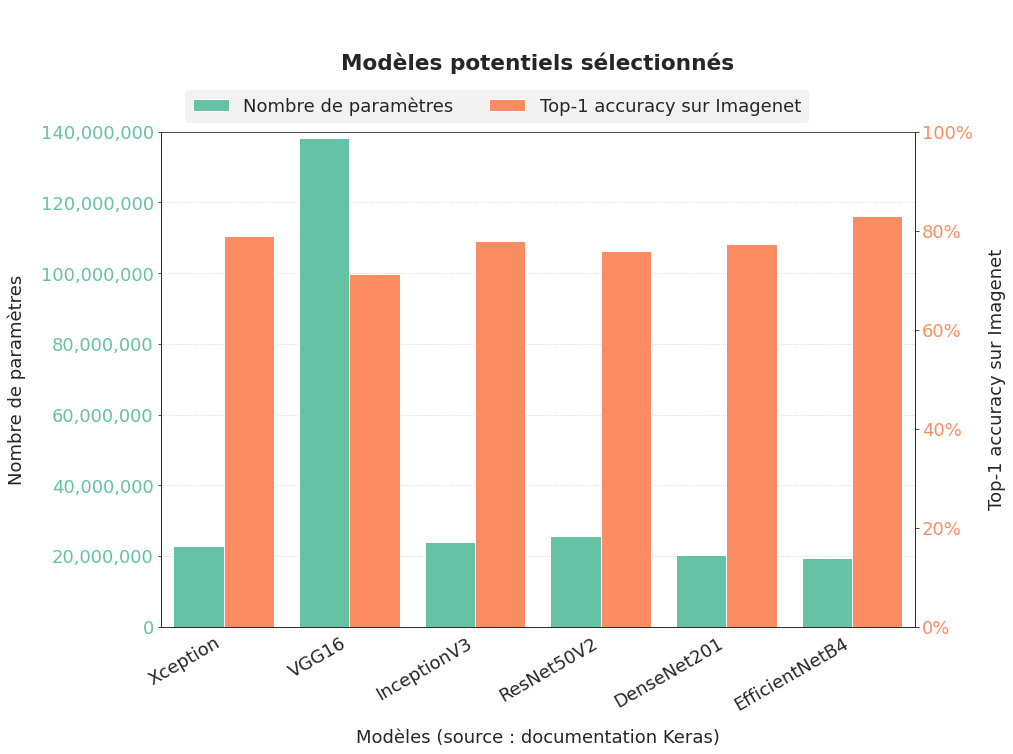

In [ ]:
graph = sfg.MyGraph("Modèles potentiels sélectionnés", y_title=1.075)
graph.add_barv(np.arange(len(base_models.model))-0.2, base_models.number_params_total,
               bar_width=0.4, label="Nombre de paramètres")
graph.add_barv(np.arange(len(base_models.model))+0.2, base_models.accuracy_imagenet,
               bar_width=0.4, color=graph.liste_couleurs[1], 
               label="Top-1 accuracy sur Imagenet", twinx=True)
graph.set_axe_x(label="Modèles (source : documentation Keras)", rotation=30, ha="right",
                tick_min=0, tick_max=len(base_models.model)-1, tick_step=1, tick_labels=base_models.model)
graph.set_axe_x(tick_min=-0.5, tick_max=len(base_models.model)-0.5)
graph.set_axe_y(label="Nombre de paramètres", tick_labels_format=":,.0f",
                tick_min=0, tick_max=140000000, color=graph.liste_couleurs[0])
graph.set_axe_y(label="Top-1 accuracy sur Imagenet", tick_labels_format=":.0%",
                tick_min=0, tick_max=1, color=graph.liste_couleurs[1], multi_index=2)
graph.set_legend(loc="center", bbox_to_anchor=(0.575, 1.125), ncol=2, multi_index=0)
fig, ax = graph.fig, graph.ax
save_fig("iml06_selection_transferlearning", tight_layout=False)
plt.show()

<a id='2_1'></a>

### 2.1. Xception

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "Xception"

In [ ]:
model = base_transfer_learning("Xception")
model.summary()

83689472/83683744 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 21,107,360
Trainable params: 245,880
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history1 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 - 305s - loss: 3.2323 - accuracy: 0.4092 - val_loss: 1.6974 - val_accuracy: 0.6851
Epoch 2/50
42/42 - 45s - loss: 0.8700 - accuracy: 0.8676 - val_loss: 0.8356 - val_accuracy: 0.8155
Epoch 3/50
42/42 - 45s - loss: 0.4356 - accuracy: 0.9286 - val_loss: 0.6696 - val_accuracy: 0.8346
Epoch 4/50
42/42 - 45s - loss: 0.2975 - accuracy: 0.9509 - val_loss: 0.6038 - val_accuracy: 0.8365
Epoch 5/50
42/42 - 45s - loss: 0.2528 - accuracy: 0.9591 - val_loss: 0.5624 - val_accuracy: 0.8453
Epoch 6/50
42/42 - 44s - loss: 0.2023 - accuracy: 0.9650 - val_loss: 0.5354 - val_accuracy: 0.8450
Epoch 7/50
42/42 - 45s - loss: 0.1547 - accuracy: 0.9710 - val_loss: 0.5266 - val_accuracy: 0.8450
Epoch 8/50
42/42 - 45s - loss: 0.1393 - accuracy: 0.9814 - val_loss: 0.5163 - val_accuracy: 0.8489
Epoch 9/50
42/42 - 45s - loss: 0.1102 - accuracy: 0.9836 - val_loss: 0.5110 - val_accuracy: 0.8471
Epoch 10/50
42/42 - 45s - loss: 0.10

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history1_csv = pd.DataFrame(history1.history)
history1_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_Xception.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,3.232346,0.409226,1.697438,0.685073
1,0.869950,0.867560,0.835648,0.815534
2,0.435649,0.928571,0.669580,0.834648
3,0.297461,0.950893,0.603850,0.836468
4,0.252777,0.959077,0.562415,0.845267


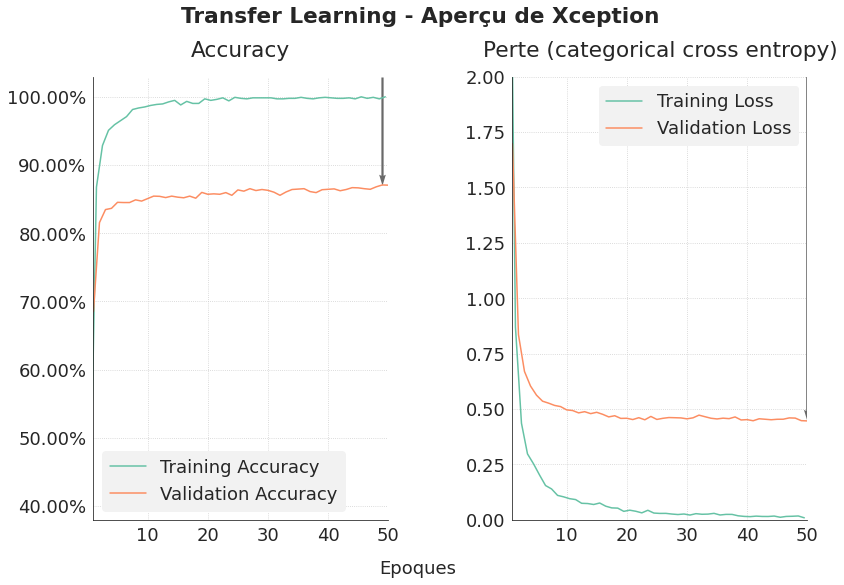

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de Xception",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 2])
plt.show()

<a id='2_2'></a>

### 2.2. VGG16

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "VGG16"

In [ ]:
model = base_transfer_learning("VGG16")
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history2 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
42/42 - 41s - loss: 13.4933 - accuracy: 0.0149 - val_loss: 9.7161 - val_accuracy: 0.0576
Epoch 2/50
42/42 - 41s - loss: 6.9918 - accuracy: 0.1228 - val_loss: 6.6198 - val_accuracy: 0.1353
Epoch 3/50
42/42 - 42s - loss: 3.8028 - accuracy: 0.3289 - val_loss: 5.1666 - val_accuracy: 0.2197
Epoch 4/50
42/42 - 42s - loss: 2.3347 - accuracy: 0.5045 - val_loss: 4.3500 - val_accuracy: 0.2752
Epoch 5/50
42/42 - 42s - loss: 1.5105 - accuracy: 0.6466 - val_loss: 3.9939 - val_accuracy: 0.3171
Epoch 6/50
42/42 - 42s - loss: 0.9745 - accuracy: 0.7560 - val_loss: 3.6639 - val_accuracy: 0.3580
Epoch 7/50
42/42 - 41s - loss: 0.7017 - accuracy: 0.8259 - val_loss: 3.4379 - val_accuracy: 0.3883
Epoch 8/50
42/42 - 42s - loss: 0.4647 - accuracy: 0.8899 - val_loss: 3.2838 - val_accuracy: 0.4105
Epoch 9/50
42/42 - 41s - loss: 0.3960 - accuracy: 0.9107 - val_loss: 3.1375 - val_accuracy: 0.4333
Epoch 10/50
42/42 - 42s - loss: 0.3163 - accuracy: 0.9338 - val_loss: 3.0688 - val_accuracy: 0.4463
Epoch 11

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history2_csv = pd.DataFrame(history2.history)
history2_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_VGG16.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,13.493299,0.014881,9.716075,0.057646
1,6.991842,0.122768,6.619754,0.135316
2,3.802832,0.328869,5.166646,0.219660
3,2.334655,0.504464,4.349979,0.275182
4,1.510546,0.646577,3.993903,0.317051


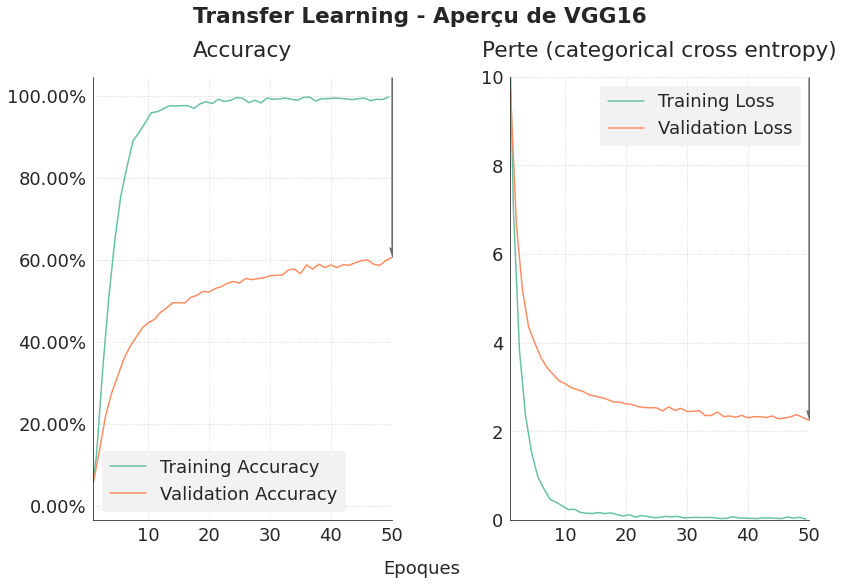

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de VGG16",
                              history_csv, is_csv=True)
plt.show()

<a id='2_3'></a>

### 2.3. InceptionV3

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "InceptionV3"

In [ ]:
model = base_transfer_learning("InceptionV3")
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history3 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
42/42 - 35s - loss: 3.1406 - accuracy: 0.4107 - val_loss: 1.3704 - val_accuracy: 0.6954
Epoch 2/50
42/42 - 34s - loss: 0.6495 - accuracy: 0.8601 - val_loss: 0.7233 - val_accuracy: 0.8137
Epoch 3/50
42/42 - 33s - loss: 0.3586 - accuracy: 0.9107 - val_loss: 0.6111 - val_accuracy: 0.8258
Epoch 4/50
42/42 - 34s - loss: 0.2545 - accuracy: 0.9442 - val_loss: 0.5678 - val_accuracy: 0.8304
Epoch 5/50
42/42 - 33s - loss: 0.1698 - accuracy: 0.9680 - val_loss: 0.5256 - val_accuracy: 0.8407
Epoch 6/50
42/42 - 33s - loss: 0.1604 - accuracy: 0.9643 - val_loss: 0.5174 - val_accuracy: 0.8474
Epoch 7/50
42/42 - 33s - loss: 0.1239 - accuracy: 0.9754 - val_loss: 0.4842 - val_accuracy: 0.8507
Epoch 8/50
42/42 - 32s - loss: 0.1052 - accuracy: 0.9799 - val_loss: 0.4805 - val_accuracy: 0.8504
Epoch 9/50
42/42 - 35s - loss: 0.0744 - accuracy: 0.9881 - val_loss: 0.4742 - val_accuracy: 0.8592
Epoch 10/50
42/42 - 32s - loss: 0.0652 - accuracy: 0.9933 - val_loss: 0.4702 - val_accuracy: 0.8577
Epoch 11/

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history3_csv = pd.DataFrame(history3.history)
history3_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_InceptionV3.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,3.140636,0.410714,1.370435,0.695388
1,0.649514,0.860119,0.723305,0.813714
2,0.358568,0.910714,0.611125,0.825850
3,0.254513,0.944196,0.567815,0.830400
4,0.169775,0.968006,0.525649,0.840716


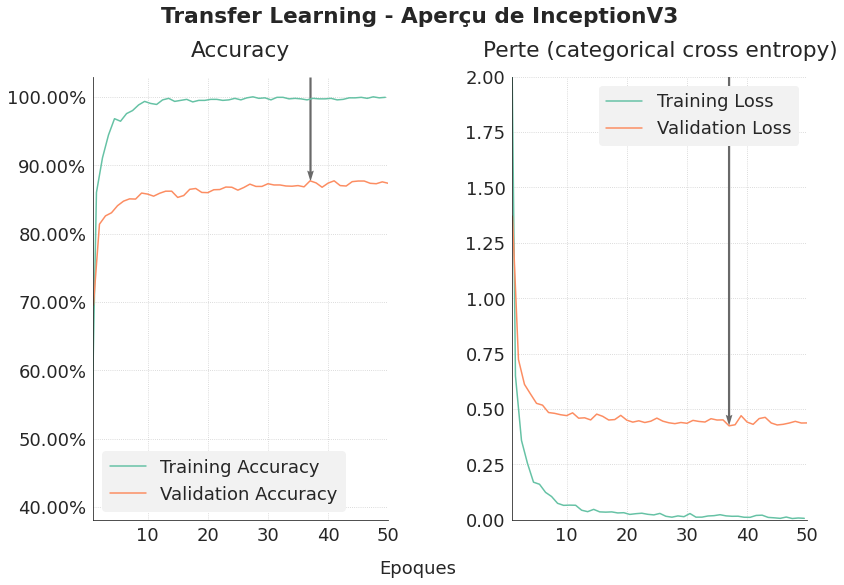

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de InceptionV3",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 2])
plt.show()

<a id='2_4'></a>

### 2.4. ResNet50V2

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "ResNet50V2"

In [ ]:
model = base_transfer_learning("ResNet50V2")
model.summary()

94674944/94668760 [==============================] - 1s 0us/step
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_2 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_2 (TensorFlo [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history4 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
42/42 - 37s - loss: 3.8373 - accuracy: 0.2262 - val_loss: 2.2344 - val_accuracy: 0.4496
Epoch 2/50
42/42 - 37s - loss: 1.1664 - accuracy: 0.7463 - val_loss: 1.3967 - val_accuracy: 0.6347
Epoch 3/50
42/42 - 37s - loss: 0.5645 - accuracy: 0.8973 - val_loss: 1.1518 - val_accuracy: 0.6878
Epoch 4/50
42/42 - 37s - loss: 0.3673 - accuracy: 0.9442 - val_loss: 1.0441 - val_accuracy: 0.7127
Epoch 5/50
42/42 - 37s - loss: 0.2520 - accuracy: 0.9665 - val_loss: 0.9809 - val_accuracy: 0.7312
Epoch 6/50
42/42 - 38s - loss: 0.1914 - accuracy: 0.9799 - val_loss: 0.9470 - val_accuracy: 0.7336
Epoch 7/50
42/42 - 38s - loss: 0.1542 - accuracy: 0.9792 - val_loss: 0.9063 - val_accuracy: 0.7421
Epoch 8/50
42/42 - 37s - loss: 0.1324 - accuracy: 0.9881 - val_loss: 0.8850 - val_accuracy: 0.7485
Epoch 9/50
42/42 - 37s - loss: 0.1018 - accuracy: 0.9911 - val_loss: 0.8725 - val_accuracy: 0.7524
Epoch 10/50
42/42 - 36s - loss: 0.0811 - accuracy: 0.9926 - val_loss: 0.8616 - val_accuracy: 0.7506
Epoch 11/

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history4_csv = pd.DataFrame(history4.history)
history4_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_ResNet50V2.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,3.837259,0.226190,2.234358,0.449636
1,1.166377,0.746280,1.396697,0.634709
2,0.564529,0.897321,1.151762,0.687803
3,0.367325,0.944196,1.044116,0.712682
4,0.252017,0.966518,0.980867,0.731189


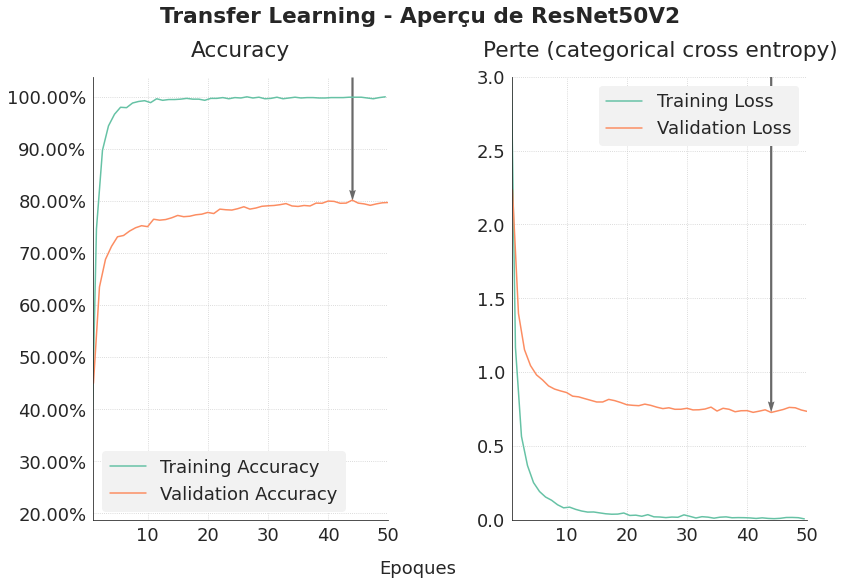

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de ResNet50V2",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 3])
plt.show()

<a id='2_5'></a>

### 2.5. DenseNet201

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "DenseNet201"

In [ ]:
model = base_transfer_learning("DenseNet201")
model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_3 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_BiasAdd_1 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv_4 (Tenso [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet201 (Functional)     (None, 1920)              18321984  
_________________________________________________________________
dense_4 (Dense)              (None, 120)               230520    
Total params: 18,552,504
Trainable params: 230,520
Non-

In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history5 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
42/42 - 52s - loss: 4.3825 - accuracy: 0.1243 - val_loss: 3.4504 - val_accuracy: 0.2603
Epoch 2/50
42/42 - 49s - loss: 2.4720 - accuracy: 0.5804 - val_loss: 2.2994 - val_accuracy: 0.5422
Epoch 3/50
42/42 - 49s - loss: 1.4402 - accuracy: 0.8110 - val_loss: 1.6434 - val_accuracy: 0.6836
Epoch 4/50
42/42 - 50s - loss: 0.8955 - accuracy: 0.9048 - val_loss: 1.3021 - val_accuracy: 0.7494
Epoch 5/50
42/42 - 50s - loss: 0.6184 - accuracy: 0.9382 - val_loss: 1.0962 - val_accuracy: 0.7837
Epoch 6/50
42/42 - 49s - loss: 0.4607 - accuracy: 0.9583 - val_loss: 0.9701 - val_accuracy: 0.8019
Epoch 7/50
42/42 - 49s - loss: 0.3446 - accuracy: 0.9777 - val_loss: 0.8981 - val_accuracy: 0.8113
Epoch 8/50
42/42 - 49s - loss: 0.2938 - accuracy: 0.9807 - val_loss: 0.8172 - val_accuracy: 0.8286
Epoch 9/50
42/42 - 49s - loss: 0.2244 - accuracy: 0.9807 - val_loss: 0.7722 - val_accuracy: 0.8362
Epoch 10/50
42/42 - 48s - loss: 0.2125 - accuracy: 0.9851 - val_loss: 0.7458 - val_accuracy: 0.8295
Epoch 11/

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history5_csv = pd.DataFrame(history5.history)
history5_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_DenseNet201.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,4.382451,0.124256,3.450419,0.260316
1,2.472044,0.580357,2.299369,0.542172
2,1.440237,0.811012,1.643414,0.683556
3,0.895545,0.904762,1.302068,0.749393
4,0.618396,0.938244,1.096161,0.783677


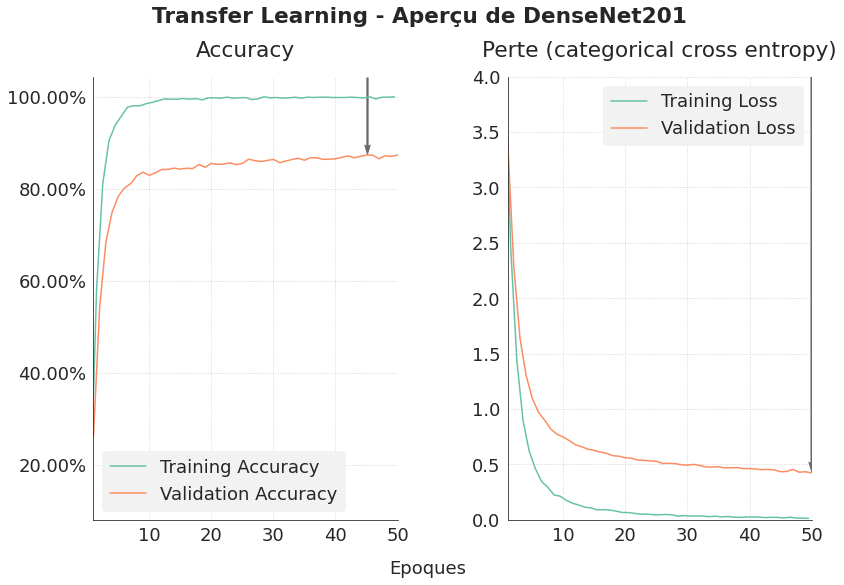

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de DenseNet201",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 4])
plt.show()

<a id='2_6'></a>

### 2.6. EfficientNetB4

In [ ]:
MODEL_NAME = "freezed_tl"
SUB_MODEL = "EfficientNetB4"

In [ ]:
model = base_transfer_learning("EfficientNetB4")
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense_5 (Dense)              (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)

In [ ]:
epochs = 50
history6 = model.fit(data_mini, validation_data=data_valid, verbose=2,
                     epochs=epochs, callbacks=[checkpoint_callback,
                                               tensorboard_callback])

Epoch 1/50
42/42 - 58s - loss: 3.9031 - accuracy: 0.3616 - val_loss: 2.8899 - val_accuracy: 0.6211
Epoch 2/50
42/42 - 57s - loss: 1.9862 - accuracy: 0.7999 - val_loss: 1.6197 - val_accuracy: 0.7715
Epoch 3/50
42/42 - 56s - loss: 1.0432 - accuracy: 0.8862 - val_loss: 1.0124 - val_accuracy: 0.8471
Epoch 4/50
42/42 - 56s - loss: 0.6242 - accuracy: 0.9323 - val_loss: 0.7554 - val_accuracy: 0.8604
Epoch 5/50
42/42 - 57s - loss: 0.4375 - accuracy: 0.9442 - val_loss: 0.6353 - val_accuracy: 0.8692
Epoch 6/50
42/42 - 56s - loss: 0.3380 - accuracy: 0.9568 - val_loss: 0.5700 - val_accuracy: 0.8708
Epoch 7/50
42/42 - 57s - loss: 0.2746 - accuracy: 0.9613 - val_loss: 0.5299 - val_accuracy: 0.8744
Epoch 8/50
42/42 - 57s - loss: 0.2281 - accuracy: 0.9725 - val_loss: 0.4955 - val_accuracy: 0.8777
Epoch 9/50
42/42 - 56s - loss: 0.1949 - accuracy: 0.9777 - val_loss: 0.4702 - val_accuracy: 0.8817
Epoch 10/50
42/42 - 55s - loss: 0.1939 - accuracy: 0.9740 - val_loss: 0.4549 - val_accuracy: 0.8768
Epoch 11/

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history6_csv = pd.DataFrame(history6.history)
history6_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_EfficientNetB4.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,3.903117,0.361607,2.889860,0.621056
1,1.986195,0.799851,1.619650,0.771541
2,1.043240,0.886161,1.012359,0.847087
3,0.624192,0.932292,0.755401,0.860437
4,0.437511,0.944196,0.635349,0.869235


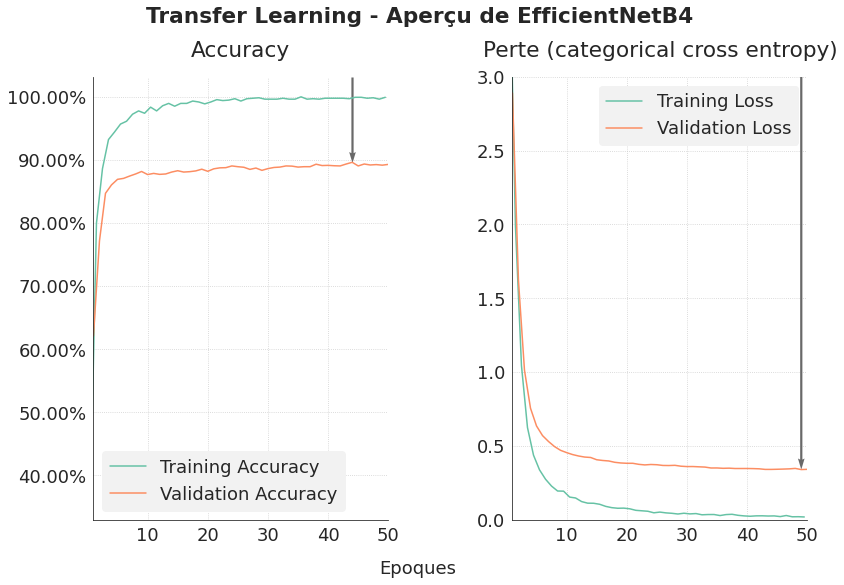

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning - Aperçu de EfficientNetB4",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 3])
plt.show()

<a id='2_7'></a>

### 2.7. Comparaison des résultats

In [ ]:
resultats = pd.DataFrame({"model": ["Xception", "VGG16", "InceptionV3",
                                    "ResNet50V2", "DenseNet201", "EfficientNetB4"],
                          "non_trainable_param": [20861480, 14714688, 21802784,
                                                  23564800, 18321984, 17673823],
                          "trainable_param": [245880, 61560, 245880,
                                              245880, 230520, 215160],
                          "training_loss": [0.0173, 0.0156, 0.0177,
                                            0.0094, 0.0128, 0.0255],
                          "validation_loss": [0.4475, 2.2451, 0.4241,
                                              0.7267, 0.4233, 0.3411],
                          "training_accuracy": [0.9970, 0.9970, 0.9955,
                                                0.9993, 1.0000, 0.9970],
                          "validation_accuracy": [0.8708, 0.6053, 0.8771,
                                                  0.8016, 0.8735, 0.8962]})
resultats

,model,non_trainable_param,trainable_param,training_loss,validation_loss,training_accuracy,validation_accuracy
0,Xception,20861480,245880,0.0173,0.4475,0.9970,0.8708
1,VGG16,14714688,61560,0.0156,2.2451,0.9970,0.6053
2,InceptionV3,21802784,245880,0.0177,0.4241,0.9955,0.8771
3,ResNet50V2,23564800,245880,0.0094,0.7267,0.9993,0.8016
4,DenseNet201,18321984,230520,0.0128,0.4233,1.0000,0.8735
5,EfficientNetB4,17673823,215160,0.0255,0.3411,0.9970,0.8962


VGG16 est le modèle qui obtient la moins bonne accuracy. On remarque que c'est le modèle qui possède le plus faible nombre de paramètres dans ses couches basses (les couches d'extraction de features). Pourtant, c'est le modèle qui possède le plus grand nombre total de paramètres (plus de 138 millions de paramètres) en incorporant les couches hautes de classification, qui sont basées sur plusieurs niveaux de couches denses. Sa bonne performance sur la base ImageNet vient donc aussi de ces couches denses. Il est moins adapté pour être réutilisé sur une nouvelle problématique.  
Le meilleur modèle est EfficientNetB4, avec une accuracy de 89,62%. C'est également le modèle qui a le moins de paramètres (après VGG16), aussi bien dans les couches non entraînables que dans les couches entraînables. Il est donc moins sujet à la sur-optimisation.  
Je choisis ce modèle. Je vais essayer d'optimiser les couches hautes qui aboutissent à la classification, pour voir si je peux encore améliorer les résultats.

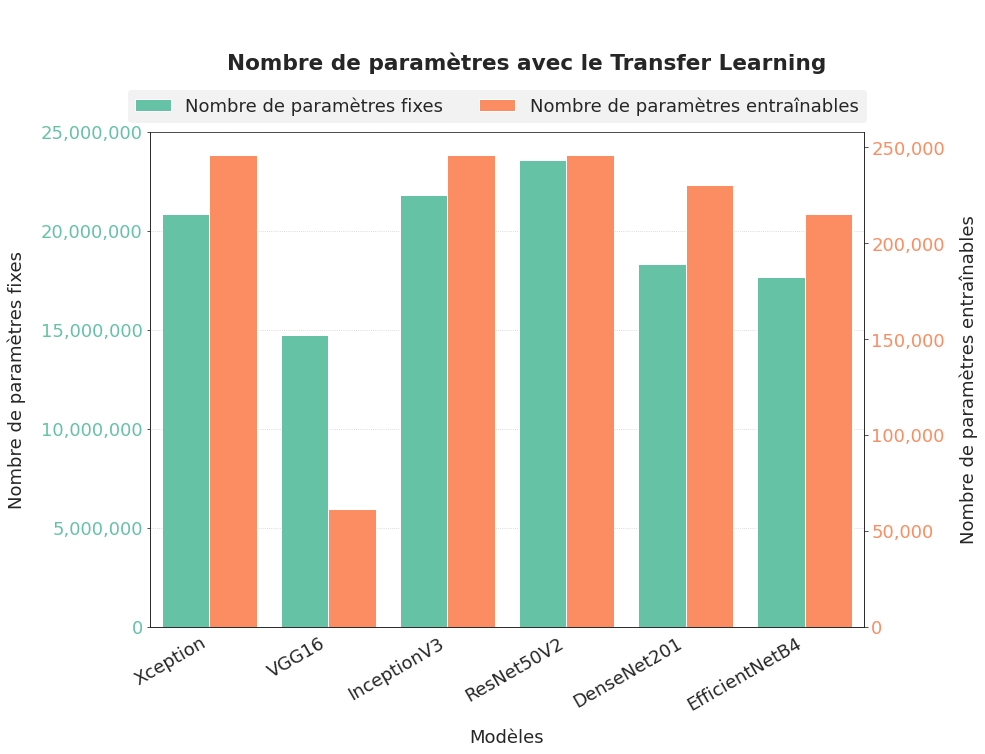

In [ ]:
graph = sfg.MyGraph("Nombre de paramètres avec le Transfer Learning", y_title=1.075)
graph.add_barv(np.arange(len(resultats.model))-0.2, resultats.non_trainable_param,
               bar_width=0.4, label="Nombre de paramètres fixes")
graph.add_barv(np.arange(len(resultats.model))+0.2, resultats.trainable_param,
               bar_width=0.4, color=graph.liste_couleurs[1], 
               label="Nombre de paramètres entraînables", twinx=True)
graph.set_axe_x(label="Modèles", rotation=30, ha="right",
                tick_min=0, tick_max=len(resultats.model)-1, tick_step=1, tick_labels=resultats.model)
graph.set_axe_x(tick_min=-0.5, tick_max=len(resultats.model)-0.5)
graph.set_axe_y(label="Nombre de paramètres fixes", tick_labels_format=":,.0f",
                tick_min=0, tick_max=25000000, tick_step= 5000000, color=graph.liste_couleurs[0])
graph.set_axe_y(label="Nombre de paramètres entraînables", tick_labels_format=":,.0f",
                tick_min=0, tick_max=250000, tick_step= 50000, color=graph.liste_couleurs[1], multi_index=2)
graph.set_legend(loc="center", bbox_to_anchor=(0.575, 1.125), ncol=2, multi_index=0)
fig, ax = graph.fig, graph.ax
save_fig("iml06_parametres_transferlearning", tight_layout=False)
plt.show()

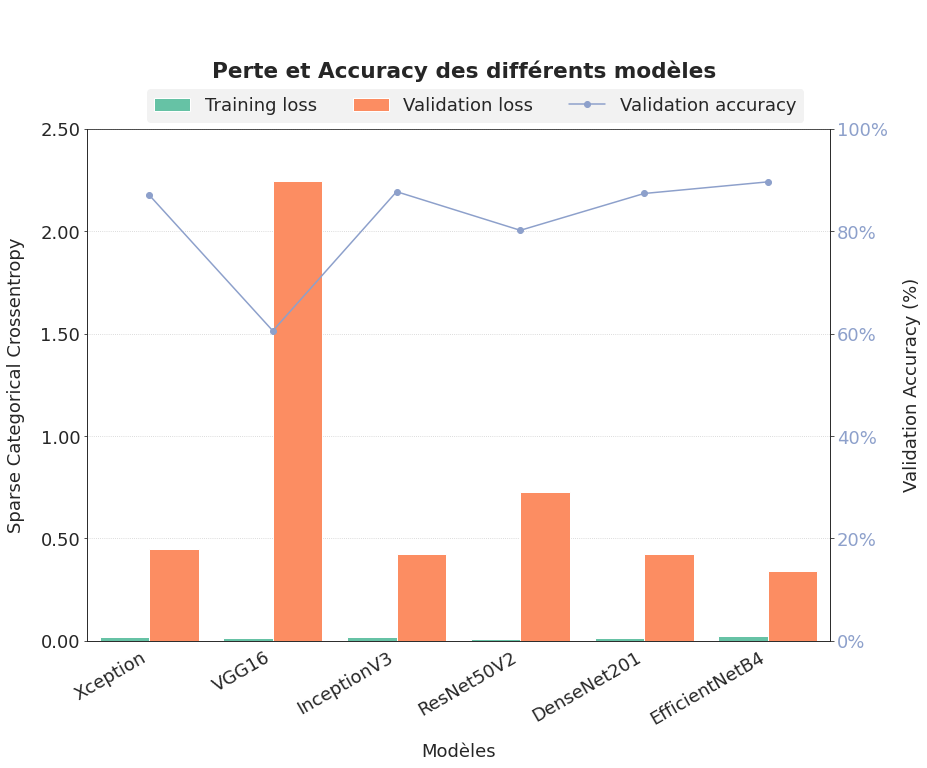

In [ ]:
graph = sfg.MyGraph("Perte et Accuracy des différents modèles", y_title=1.085)
graph.add_barv(np.arange(len(resultats.model))-0.2, resultats.training_loss,
               bar_width=0.4, label="Training loss")
graph.add_barv(np.arange(len(resultats.model))+0.2, resultats.validation_loss,
               bar_width=0.4, label="Validation loss")
graph.add_plot(np.arange(len(resultats.model)), resultats.validation_accuracy, marker="o",
               color=graph.liste_couleurs[2], label="Validation accuracy", twinx=True)
graph.set_axe_x(label="Modèles", rotation=30, ha="right",
                tick_min=0, tick_max=len(resultats.model)-1, tick_step=1, tick_labels=resultats.model)
graph.set_axe_x(tick_min=-0.5, tick_max=len(resultats.model)-0.5)
graph.set_axe_y(label="Sparse Categorical Crossentropy", tick_labels_format=":.2f",
                tick_min=0, tick_max=2.5, tick_step=0.5)
graph.set_axe_y(label="Validation Accuracy (%)", tick_labels_format=":.0%",
                tick_min=0, tick_max=1, color=graph.liste_couleurs[2], multi_index=2)
graph.set_legend(loc="center", bbox_to_anchor=(0.55, 1.15), ncol=3, multi_index=0)
fig, ax = graph.fig, graph.ax
save_fig("iml06_performance_transferlearning", tight_layout=False)
plt.show()

---
<a id='3_0'></a>

## <font color=blue>3. Optimisation du modèle basé sur EfficientNetB4</font>

Je cherche à définir la construction idéale pour ma classification basée sur les features en sortie du transfer learning.

### 3.1. Premier essai d'optimisation

Je réalise d'abord une recherche large, dans le but de trouver les meilleures orientations pour :
- la taille de l'image en entrée du modèle pré-entraîné ;
- la stratégie de sortie du modèle pré-entraîné : flatten, global max pooling ou global average pooling ;
- le nombre de couches denses, avec un dropout, avant ma couche de classification : 0, 1 ou 2 ;
- le nombre de neurones pour chacune de ces couches denses : entre 120 et 480 par pas de 120 ;
- la fonction d'activation pour chacune de ces couches denses : ReLU, tanh, sigmoid ou ELU ;
- le taux de dropout pour chacune de ces couches denses : entre 20% et 60% par pas de 10%.

In [ ]:
percent_data = 0.1
data_mini = data_train.take(int(np.ceil(percent_data * data_train.cardinality().numpy())))
print(data_mini.cardinality().numpy())

42


In [ ]:
def optim_efficientnetb4(hp):
    inputs = Input(shape=(256, 256, 3), dtype=tf.float32)
    img_size = hp.Int("img_size", min_value=128, max_value=256, step=32, default=256)
    x = Resizing(img_size, img_size)(inputs)
    x = efficientnet_preprocess_input(x)
    output_transfo = hp.Choice("pooling", ["none", "avg", "max"], default="avg")
    base_model = EfficientNetB4(include_top=False,
                                weights="imagenet",
                                input_shape=(img_size, img_size, 3),
                                pooling=output_transfo)
    base_model.trainable = False
    x = base_model(x)
    if output_transfo == "none":
        x = Flatten()(x)
    nb_layers = hp.Int("nb_layers", 0, 2)
    if nb_layers > 0:
        for i in range(nb_layers):
            dense_layer = Dense(units=hp.Int("units_" + str(i),
                                             min_value=120,
                                             max_value=480,
                                             step=120,
                                             default=240),
                                activation=hp.Choice("activation_" + str(i),
                                                     values=["relu", "tanh", "sigmoid", "elu"],
                                                     default="relu"))
            dropout_regul = Dropout(rate=hp.Float("rate_" + str(i),
                                                  min_value=0.2,
                                                  max_value=0.6,
                                                  step=0.1),
                                    seed=RANDOM_SEED)
            x = dense_layer(x)
            x = dropout_regul(x)
    outputs = Dense(120, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

In [ ]:
tuner = BayesianOptimization(optim_efficientnetb4,
                             objective="val_accuracy",
                             max_trials=50,
                             executions_per_trial=1,
                             directory="tuning",
                             project_name="efficientnet",
                             seed=RANDOM_SEED)

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
tuner.search(data_mini, validation_data=data_valid, verbose=1,
             epochs=10)

Epoch 1/10
42/42 [==============================] - 329s 8s/step - loss: 5.7810 - accuracy: 0.0707 - val_loss: 4.0899 - val_accuracy: 0.1553
Epoch 2/10
42/42 [==============================] - 49s 1s/step - loss: 3.3205 - accuracy: 0.2634 - val_loss: 3.2110 - val_accuracy: 0.3280
Epoch 3/10
42/42 [==============================] - 49s 1s/step - loss: 2.1752 - accuracy: 0.4799 - val_loss: 2.4265 - val_accuracy: 0.4700
Epoch 4/10
42/42 [==============================] - 49s 1s/step - loss: 1.5143 - accuracy: 0.6429 - val_loss: 2.1518 - val_accuracy: 0.5276
Epoch 5/10
42/42 [==============================] - 49s 1s/step - loss: 1.2099 - accuracy: 0.6987 - val_loss: 2.1057 - val_accuracy: 0.5458
Epoch 6/10
42/42 [==============================] - 49s 1s/step - loss: 1.1249 - accuracy: 0.7277 - val_loss: 2.0263 - val_accuracy: 0.5828
Epoch 7/10
42/42 [==============================] - 49s 1s/step - loss: 0.7873 - accuracy: 0.7865 - val_loss: 1.8508 - val_accuracy: 0.6253
Epoch 8/10
42/42 [=

Epoch 1/10
42/42 [==============================] - 36s 867ms/step - loss: 4.9051 - accuracy: 0.0945 - val_loss: 3.3120 - val_accuracy: 0.3061
Epoch 2/10
42/42 [==============================] - 35s 833ms/step - loss: 2.7905 - accuracy: 0.3780 - val_loss: 2.5715 - val_accuracy: 0.4311
Epoch 3/10
42/42 [==============================] - 35s 843ms/step - loss: 1.9012 - accuracy: 0.5603 - val_loss: 2.0735 - val_accuracy: 0.5306
Epoch 4/10
42/42 [==============================] - 36s 858ms/step - loss: 1.3107 - accuracy: 0.6719 - val_loss: 1.9481 - val_accuracy: 0.5598
Epoch 5/10
42/42 [==============================] - 35s 840ms/step - loss: 0.9332 - accuracy: 0.7411 - val_loss: 1.9636 - val_accuracy: 0.5610
Epoch 6/10
42/42 [==============================] - 36s 861ms/step - loss: 0.8929 - accuracy: 0.7612 - val_loss: 1.9187 - val_accuracy: 0.5640
Epoch 7/10
42/42 [==============================] - 36s 850ms/step - loss: 0.7712 - accuracy: 0.7924 - val_loss: 1.8653 - val_accuracy: 0.5938

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.3844 - accuracy: 0.2798 - val_loss: 1.9164 - val_accuracy: 0.6035
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.1756 - accuracy: 0.7284 - val_loss: 0.9689 - val_accuracy: 0.7646
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6738 - accuracy: 0.8274 - val_loss: 1.1254 - val_accuracy: 0.7615
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.4846 - accuracy: 0.8757 - val_loss: 1.0481 - val_accuracy: 0.7779
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.3837 - accuracy: 0.8869 - val_loss: 0.9630 - val_accuracy: 0.7964
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3381 - accuracy: 0.9025 - val_loss: 1.0983 - val_accuracy: 0.7885
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.2422 - accuracy: 0.9345 - val_loss: 0.9655 - val_accuracy: 0.8089
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 4.9705 - accuracy: 0.0699 - val_loss: 3.4942 - val_accuracy: 0.2867
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 2.9497 - accuracy: 0.3497 - val_loss: 1.8303 - val_accuracy: 0.5859
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 1.6534 - accuracy: 0.5938 - val_loss: 1.0404 - val_accuracy: 0.7221
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 1.2418 - accuracy: 0.6533 - val_loss: 0.8890 - val_accuracy: 0.7482
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 1.0473 - accuracy: 0.6882 - val_loss: 0.7802 - val_accuracy: 0.7809
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.9122 - accuracy: 0.7470 - val_loss: 0.7923 - val_accuracy: 0.7767
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.7855 - accuracy: 0.7693 - val_loss: 0.7450 - val_accuracy: 0.7961
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 6.0379 - accuracy: 0.0141 - val_loss: 4.8049 - val_accuracy: 0.0355
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 5.4080 - accuracy: 0.0126 - val_loss: 4.5816 - val_accuracy: 0.0473
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 5.0706 - accuracy: 0.0290 - val_loss: 4.2950 - val_accuracy: 0.1192
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 4.9047 - accuracy: 0.0446 - val_loss: 3.8510 - val_accuracy: 0.1599
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 4.7096 - accuracy: 0.0707 - val_loss: 3.6028 - val_accuracy: 0.2400
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 4.5892 - accuracy: 0.0707 - val_loss: 3.3786 - val_accuracy: 0.2761
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 4.4045 - accuracy: 0.0930 - val_loss: 3.2030 - val_accuracy: 0.2621
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 30s 718ms/step - loss: 4.6183 - accuracy: 0.1868 - val_loss: 2.6309 - val_accuracy: 0.3865
Epoch 2/10
42/42 [==============================] - 28s 666ms/step - loss: 1.6646 - accuracy: 0.5714 - val_loss: 2.1787 - val_accuracy: 0.4651
Epoch 3/10
42/42 [==============================] - 28s 655ms/step - loss: 1.0650 - accuracy: 0.7135 - val_loss: 2.1378 - val_accuracy: 0.4903
Epoch 4/10
42/42 [==============================] - 28s 656ms/step - loss: 0.8065 - accuracy: 0.7805 - val_loss: 1.9914 - val_accuracy: 0.5240
Epoch 5/10
42/42 [==============================] - 28s 663ms/step - loss: 0.5732 - accuracy: 0.8475 - val_loss: 1.8945 - val_accuracy: 0.5407
Epoch 6/10
42/42 [==============================] - 28s 658ms/step - loss: 0.4443 - accuracy: 0.8951 - val_loss: 1.8997 - val_accuracy: 0.5410
Epoch 7/10
42/42 [==============================] - 28s 659ms/step - loss: 0.3539 - accuracy: 0.9174 - val_loss: 1.8583 - val_accuracy: 0.5680

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 14.4132 - accuracy: 0.3683 - val_loss: 7.8928 - val_accuracy: 0.5774
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 3.4425 - accuracy: 0.8237 - val_loss: 7.5980 - val_accuracy: 0.6556
Epoch 3/10
42/42 [==============================] - 56s 1s/step - loss: 2.0358 - accuracy: 0.8891 - val_loss: 7.1950 - val_accuracy: 0.6878
Epoch 4/10
42/42 [==============================] - 56s 1s/step - loss: 1.5692 - accuracy: 0.9182 - val_loss: 7.3602 - val_accuracy: 0.6908
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 1.3201 - accuracy: 0.9286 - val_loss: 8.2826 - val_accuracy: 0.6787
Epoch 6/10
42/42 [==============================] - 56s 1s/step - loss: 1.3537 - accuracy: 0.9345 - val_loss: 7.7773 - val_accuracy: 0.7106
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.9416 - accuracy: 0.9501 - val_loss: 8.4450 - val_accuracy: 0.7012
Epoch 8/10
42/42 [=

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.4977 - accuracy: 0.2887 - val_loss: 1.7434 - val_accuracy: 0.6019
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0633 - accuracy: 0.7336 - val_loss: 1.1231 - val_accuracy: 0.7282
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.5492 - accuracy: 0.8445 - val_loss: 0.9009 - val_accuracy: 0.7925
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.4056 - accuracy: 0.8884 - val_loss: 0.9120 - val_accuracy: 0.7894
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3545 - accuracy: 0.8958 - val_loss: 1.1767 - val_accuracy: 0.7658
Epoch 6/10
42/42 [==============================] - 55s 1s/step - loss: 0.3264 - accuracy: 0.9077 - val_loss: 0.9967 - val_accuracy: 0.7967
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.2825 - accuracy: 0.9249 - val_loss: 0.9500 - val_accuracy: 0.8137
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.5595 - accuracy: 0.2701 - val_loss: 1.6582 - val_accuracy: 0.6068
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.0053 - accuracy: 0.7522 - val_loss: 1.1299 - val_accuracy: 0.7482
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6653 - accuracy: 0.8185 - val_loss: 1.0472 - val_accuracy: 0.7734
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.5504 - accuracy: 0.8549 - val_loss: 1.1222 - val_accuracy: 0.7673
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4624 - accuracy: 0.8646 - val_loss: 1.0069 - val_accuracy: 0.7861
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3213 - accuracy: 0.9010 - val_loss: 0.9882 - val_accuracy: 0.8004
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.2897 - accuracy: 0.9159 - val_loss: 0.9301 - val_accuracy: 0.8213
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 58s 1s/step - loss: 14.6255 - accuracy: 0.3542 - val_loss: 8.5403 - val_accuracy: 0.5543
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 3.0532 - accuracy: 0.8356 - val_loss: 5.5357 - val_accuracy: 0.7069
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 1.7086 - accuracy: 0.8966 - val_loss: 6.4871 - val_accuracy: 0.6902
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 1.4232 - accuracy: 0.9107 - val_loss: 7.5912 - val_accuracy: 0.6672
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 1.0967 - accuracy: 0.9345 - val_loss: 8.4286 - val_accuracy: 0.6647
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.9086 - accuracy: 0.9501 - val_loss: 7.4767 - val_accuracy: 0.6857
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 1.1514 - accuracy: 0.9360 - val_loss: 8.5006 - val_accuracy: 0.6969
Epoch 8/10
42/42 [=

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.3244 - accuracy: 0.2909 - val_loss: 1.6025 - val_accuracy: 0.6183
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.1166 - accuracy: 0.7262 - val_loss: 1.3250 - val_accuracy: 0.7118
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6487 - accuracy: 0.8333 - val_loss: 0.9374 - val_accuracy: 0.7888
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4418 - accuracy: 0.8713 - val_loss: 1.2887 - val_accuracy: 0.7582
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4533 - accuracy: 0.8810 - val_loss: 0.9858 - val_accuracy: 0.7888
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3218 - accuracy: 0.9122 - val_loss: 0.9918 - val_accuracy: 0.7985
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.2435 - accuracy: 0.9234 - val_loss: 0.9526 - val_accuracy: 0.8079
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.4809 - accuracy: 0.2842 - val_loss: 1.5909 - val_accuracy: 0.6471
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0070 - accuracy: 0.7582 - val_loss: 1.1573 - val_accuracy: 0.7327
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6422 - accuracy: 0.8393 - val_loss: 1.1466 - val_accuracy: 0.7515
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.5680 - accuracy: 0.8534 - val_loss: 1.0187 - val_accuracy: 0.7870
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.4101 - accuracy: 0.8802 - val_loss: 0.9665 - val_accuracy: 0.7952
Epoch 6/10
42/42 [==============================] - 55s 1s/step - loss: 0.3903 - accuracy: 0.9033 - val_loss: 0.9693 - val_accuracy: 0.8028
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.3498 - accuracy: 0.9062 - val_loss: 0.9561 - val_accuracy: 0.8174
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.3826 - accuracy: 0.2939 - val_loss: 1.6627 - val_accuracy: 0.6189
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0240 - accuracy: 0.7485 - val_loss: 1.2734 - val_accuracy: 0.7294
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6313 - accuracy: 0.8214 - val_loss: 1.1366 - val_accuracy: 0.7703
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.5791 - accuracy: 0.8661 - val_loss: 1.0419 - val_accuracy: 0.7897
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.3160 - accuracy: 0.9144 - val_loss: 1.0236 - val_accuracy: 0.7955
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3393 - accuracy: 0.9025 - val_loss: 1.0158 - val_accuracy: 0.8001
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.2955 - accuracy: 0.9241 - val_loss: 1.0501 - val_accuracy: 0.8089
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 30s 708ms/step - loss: 4.5271 - accuracy: 0.1897 - val_loss: 2.5381 - val_accuracy: 0.3877
Epoch 2/10
42/42 [==============================] - 28s 657ms/step - loss: 1.6464 - accuracy: 0.5618 - val_loss: 2.1860 - val_accuracy: 0.4727
Epoch 3/10
42/42 [==============================] - 28s 662ms/step - loss: 1.0743 - accuracy: 0.7098 - val_loss: 2.0367 - val_accuracy: 0.5073
Epoch 4/10
42/42 [==============================] - 28s 659ms/step - loss: 0.7952 - accuracy: 0.7946 - val_loss: 2.0486 - val_accuracy: 0.5176
Epoch 5/10
42/42 [==============================] - 28s 665ms/step - loss: 0.6036 - accuracy: 0.8482 - val_loss: 1.9783 - val_accuracy: 0.5322
Epoch 6/10
42/42 [==============================] - 28s 660ms/step - loss: 0.4805 - accuracy: 0.8891 - val_loss: 1.9576 - val_accuracy: 0.5331
Epoch 7/10
42/42 [==============================] - 28s 661ms/step - loss: 0.3658 - accuracy: 0.9033 - val_loss: 1.9664 - val_accuracy: 0.5482

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.6242 - accuracy: 0.2589 - val_loss: 1.6856 - val_accuracy: 0.6089
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.0440 - accuracy: 0.7478 - val_loss: 1.1924 - val_accuracy: 0.7351
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.5978 - accuracy: 0.8304 - val_loss: 1.0201 - val_accuracy: 0.7685
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4304 - accuracy: 0.8713 - val_loss: 0.9809 - val_accuracy: 0.7819
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4288 - accuracy: 0.8810 - val_loss: 1.0535 - val_accuracy: 0.7819
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3879 - accuracy: 0.8996 - val_loss: 0.9302 - val_accuracy: 0.8046
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.2748 - accuracy: 0.9323 - val_loss: 0.9609 - val_accuracy: 0.7961
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.8050 - accuracy: 0.2545 - val_loss: 1.5976 - val_accuracy: 0.6429
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.1427 - accuracy: 0.7158 - val_loss: 1.1727 - val_accuracy: 0.7260
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6001 - accuracy: 0.8356 - val_loss: 1.1317 - val_accuracy: 0.7600
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.5079 - accuracy: 0.8542 - val_loss: 1.1995 - val_accuracy: 0.7618
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3939 - accuracy: 0.8832 - val_loss: 0.9640 - val_accuracy: 0.7925
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3249 - accuracy: 0.9033 - val_loss: 1.0621 - val_accuracy: 0.7846
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.3197 - accuracy: 0.9010 - val_loss: 1.0134 - val_accuracy: 0.8076
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.8042 - accuracy: 0.2626 - val_loss: 1.7426 - val_accuracy: 0.6171
Epoch 2/10
42/42 [==============================] - 55s 1s/step - loss: 1.1021 - accuracy: 0.7336 - val_loss: 1.1033 - val_accuracy: 0.7394
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6324 - accuracy: 0.8304 - val_loss: 1.0001 - val_accuracy: 0.7773
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4382 - accuracy: 0.8817 - val_loss: 1.0603 - val_accuracy: 0.7809
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.3630 - accuracy: 0.8921 - val_loss: 0.9709 - val_accuracy: 0.7943
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3245 - accuracy: 0.9062 - val_loss: 0.9044 - val_accuracy: 0.8101
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.2715 - accuracy: 0.9189 - val_loss: 1.0224 - val_accuracy: 0.8013
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.3318 - accuracy: 0.2887 - val_loss: 1.4869 - val_accuracy: 0.6478
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 0.9258 - accuracy: 0.7507 - val_loss: 1.3098 - val_accuracy: 0.7285
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6942 - accuracy: 0.8237 - val_loss: 1.1364 - val_accuracy: 0.7479
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4974 - accuracy: 0.8705 - val_loss: 1.0345 - val_accuracy: 0.7849
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4643 - accuracy: 0.8854 - val_loss: 1.0326 - val_accuracy: 0.7913
Epoch 6/10
42/42 [==============================] - 55s 1s/step - loss: 0.3648 - accuracy: 0.8899 - val_loss: 0.8802 - val_accuracy: 0.8192
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.2591 - accuracy: 0.9256 - val_loss: 0.9337 - val_accuracy: 0.8067
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.5969 - accuracy: 0.2842 - val_loss: 1.7384 - val_accuracy: 0.6235
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0685 - accuracy: 0.7448 - val_loss: 1.1054 - val_accuracy: 0.7445
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.7033 - accuracy: 0.8170 - val_loss: 1.1456 - val_accuracy: 0.7600
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4839 - accuracy: 0.8579 - val_loss: 1.0255 - val_accuracy: 0.7785
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.4066 - accuracy: 0.8757 - val_loss: 0.9071 - val_accuracy: 0.8043
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3290 - accuracy: 0.9070 - val_loss: 0.9269 - val_accuracy: 0.8122
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.3194 - accuracy: 0.9174 - val_loss: 0.9994 - val_accuracy: 0.8064
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 4.5804 - accuracy: 0.1220 - val_loss: 2.7497 - val_accuracy: 0.4505
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 2.1478 - accuracy: 0.4948 - val_loss: 1.2362 - val_accuracy: 0.6723
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 1.3821 - accuracy: 0.6317 - val_loss: 0.9662 - val_accuracy: 0.7379
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 1.0002 - accuracy: 0.7076 - val_loss: 0.8763 - val_accuracy: 0.7461
Epoch 5/10
42/42 [==============================] - 55s 1s/step - loss: 0.8790 - accuracy: 0.7515 - val_loss: 0.8187 - val_accuracy: 0.7640
Epoch 6/10
42/42 [==============================] - 55s 1s/step - loss: 0.8226 - accuracy: 0.7619 - val_loss: 0.8186 - val_accuracy: 0.7776
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.7401 - accuracy: 0.7835 - val_loss: 0.6719 - val_accuracy: 0.8095
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.1611 - accuracy: 0.2909 - val_loss: 1.4942 - val_accuracy: 0.6572
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 0.9303 - accuracy: 0.7515 - val_loss: 1.3210 - val_accuracy: 0.7212
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6362 - accuracy: 0.8371 - val_loss: 1.0307 - val_accuracy: 0.7803
Epoch 4/10
42/42 [==============================] - 55s 1s/step - loss: 0.4816 - accuracy: 0.8705 - val_loss: 0.9694 - val_accuracy: 0.7900
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3751 - accuracy: 0.8906 - val_loss: 1.1279 - val_accuracy: 0.7900
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.4433 - accuracy: 0.8824 - val_loss: 1.1875 - val_accuracy: 0.7891
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.3303 - accuracy: 0.9107 - val_loss: 1.1115 - val_accuracy: 0.7825
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 57s 1s/step - loss: 5.4861 - accuracy: 0.2716 - val_loss: 1.6482 - val_accuracy: 0.6347
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 0.9982 - accuracy: 0.7455 - val_loss: 1.1917 - val_accuracy: 0.7309
Epoch 3/10
42/42 [==============================] - 55s 1s/step - loss: 0.6588 - accuracy: 0.8147 - val_loss: 1.1057 - val_accuracy: 0.7646
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4776 - accuracy: 0.8661 - val_loss: 0.9808 - val_accuracy: 0.7934
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3767 - accuracy: 0.8884 - val_loss: 0.9671 - val_accuracy: 0.8083
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.2581 - accuracy: 0.9286 - val_loss: 1.0029 - val_accuracy: 0.7949
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.2935 - accuracy: 0.9129 - val_loss: 1.1092 - val_accuracy: 0.7931
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.8353 - accuracy: 0.2582 - val_loss: 1.8529 - val_accuracy: 0.5931
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0207 - accuracy: 0.7493 - val_loss: 1.1782 - val_accuracy: 0.7312
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.5750 - accuracy: 0.8341 - val_loss: 1.0501 - val_accuracy: 0.7712
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.5017 - accuracy: 0.8519 - val_loss: 1.0593 - val_accuracy: 0.7785
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4753 - accuracy: 0.8772 - val_loss: 0.9688 - val_accuracy: 0.8086
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3704 - accuracy: 0.9040 - val_loss: 0.9746 - val_accuracy: 0.8025
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.3689 - accuracy: 0.8973 - val_loss: 1.0371 - val_accuracy: 0.8037
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.4354 - accuracy: 0.2470 - val_loss: 1.6563 - val_accuracy: 0.6380
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0902 - accuracy: 0.7381 - val_loss: 1.1208 - val_accuracy: 0.7497
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6411 - accuracy: 0.8363 - val_loss: 1.1285 - val_accuracy: 0.7676
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.5371 - accuracy: 0.8512 - val_loss: 0.9167 - val_accuracy: 0.7952
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3719 - accuracy: 0.8899 - val_loss: 0.9946 - val_accuracy: 0.7982
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3324 - accuracy: 0.8988 - val_loss: 1.0197 - val_accuracy: 0.7979
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.4286 - accuracy: 0.8906 - val_loss: 1.0026 - val_accuracy: 0.8146
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.6804 - accuracy: 0.0119 - val_loss: 4.5981 - val_accuracy: 0.0840
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 4.5795 - accuracy: 0.0603 - val_loss: 4.3447 - val_accuracy: 0.1635
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 4.2920 - accuracy: 0.0885 - val_loss: 3.9387 - val_accuracy: 0.2931
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 3.8312 - accuracy: 0.1711 - val_loss: 3.3289 - val_accuracy: 0.3595
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 3.4674 - accuracy: 0.2232 - val_loss: 2.8520 - val_accuracy: 0.4524
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 3.1864 - accuracy: 0.2731 - val_loss: 2.3796 - val_accuracy: 0.5294
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 2.8735 - accuracy: 0.2946 - val_loss: 1.9817 - val_accuracy: 0.5768
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.7097 - accuracy: 0.2827 - val_loss: 1.7730 - val_accuracy: 0.6244
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0644 - accuracy: 0.7351 - val_loss: 1.0543 - val_accuracy: 0.7561
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.7174 - accuracy: 0.8103 - val_loss: 1.0940 - val_accuracy: 0.7673
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.5003 - accuracy: 0.8616 - val_loss: 1.1211 - val_accuracy: 0.7709
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.4349 - accuracy: 0.8757 - val_loss: 1.2258 - val_accuracy: 0.7609
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3444 - accuracy: 0.8988 - val_loss: 1.0513 - val_accuracy: 0.7961
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.3247 - accuracy: 0.9129 - val_loss: 1.0203 - val_accuracy: 0.8007
Epoch 8/10
42/42 [==

Epoch 1/10
42/42 [==============================] - 56s 1s/step - loss: 5.3059 - accuracy: 0.2634 - val_loss: 1.8454 - val_accuracy: 0.6001
Epoch 2/10
42/42 [==============================] - 54s 1s/step - loss: 1.0749 - accuracy: 0.7344 - val_loss: 1.1817 - val_accuracy: 0.7388
Epoch 3/10
42/42 [==============================] - 54s 1s/step - loss: 0.6522 - accuracy: 0.8460 - val_loss: 1.0675 - val_accuracy: 0.7591
Epoch 4/10
42/42 [==============================] - 54s 1s/step - loss: 0.4357 - accuracy: 0.8765 - val_loss: 0.8649 - val_accuracy: 0.8070
Epoch 5/10
42/42 [==============================] - 54s 1s/step - loss: 0.3708 - accuracy: 0.8891 - val_loss: 0.8913 - val_accuracy: 0.8055
Epoch 6/10
42/42 [==============================] - 54s 1s/step - loss: 0.3440 - accuracy: 0.9048 - val_loss: 0.9772 - val_accuracy: 0.8007
Epoch 7/10
42/42 [==============================] - 54s 1s/step - loss: 0.3524 - accuracy: 0.9040 - val_loss: 0.9379 - val_accuracy: 0.8037
Epoch 8/10
42/42 [==

Epoch 1/10
 9/42 [=====>........................] - ETA: 11s - loss: 10.2687 - accuracy: 0.0382

In [ ]:
tuner.results_summary()

L'optimisation n'a pas eu le temps de se finir par manque d'espace de stockage sur mon Google Drive.  
J'ai dû supprimer les logs de Keras Tuner.  
Je vérifie les résultats visibles dans la cellule de sortie.

Différentes conclusions ressortent de ces résultats :
- Les meilleurs résultats sont obtenus avec des images plus grandes (taille de 256x256) ;
- Les meilleurs résultats sont obtenus avec un pooling -> on ne garde que max ou avg ;
- Les meilleurs résultats sont obtenus avec aucune couche dense intermédiaire (nb_layers = 0) ;
- Une autre solution intéressante semble être 2 couches denses avec 480 neurones sur la première couche, 240 ou 480 neurones sur la deuxième couche, un dropout de 20% sur chaque couche, des fonctions d'activation elu ou relu.

Je refais tourner une optimisation sur cette base.

<a id='3_2'></a>

### 3.2. Deuxième essai d'optimisation

Cette optimisation plus ciblée se concentre sur les éléments suivants :
- la stratégie de sortie du modèle pré-entraîné : global average pooling ou global max pooling ;
- le nombre de couches denses, avec un dropout de 20%, avant ma couche de classification : 0 ou 2 ;
- le nombre de neurones pour la deuxième couche dense s'il y a deux couches denses : 240 ou 480 (la première couche dense est fixée à 480 neurones) ;
- la fonction d'activation pour chacune des deux couches denses s'il y a deux couches denses : ReLU ou ELU ;

In [ ]:
percent_data = 0.1
data_mini = data_train.take(int(np.ceil(percent_data * data_train.cardinality().numpy())))
print(data_mini.cardinality().numpy())

42


In [ ]:
def optim_transferlearning(hp):
    inputs = Input(shape=(256, 256, 3), dtype=tf.float32)
    x = efficientnet_preprocess_input(inputs)
    output_transfo = hp.Choice("pooling", ["avg", "max"])
    base_model = EfficientNetB4(include_top=False,
                                weights="imagenet",
                                input_shape=(256, 256, 3),
                                pooling=output_transfo)
    base_model.trainable = False
    x = base_model(x)
    nb_layers = hp.Choice("nb_layers", [0, 2])
    if nb_layers == 2:
        x = Dense(units=480,
                  activation=hp.Choice("activation_1",
                                       values=["relu", "elu"]))(x)
        x = Dropout(rate=0.2, seed=RANDOM_SEED)(x)
        x = Dense(units=hp.Choice("units_2", values=[240, 480]),
                  activation=hp.Choice("activation_2",
                                       values=["relu", "elu"]))(x)
        x = Dropout(rate=0.2, seed=RANDOM_SEED)(x)
    outputs = Dense(120, activation="softmax")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="adam",
                  metrics=["accuracy"])
    return model

In [ ]:
tuner = BayesianOptimization(optim_transferlearning,
                             objective="val_accuracy",
                             max_trials=20,
                             executions_per_trial=1,
                             directory="tuning",
                             project_name="efficientnet2",
                             seed=RANDOM_SEED)

71688192/71686520 [==============================] - 1s 0us/step


In [ ]:
tuner.search(data_mini, validation_data=data_valid, verbose=2,
             epochs=10)

Epoch 1/10
42/42 - 389s - loss: 3.9288 - accuracy: 0.3490 - val_loss: 2.9501 - val_accuracy: 0.5871
Epoch 2/10
42/42 - 71s - loss: 2.0369 - accuracy: 0.7865 - val_loss: 1.6442 - val_accuracy: 0.7803
Epoch 3/10
42/42 - 70s - loss: 1.0536 - accuracy: 0.8876 - val_loss: 1.0384 - val_accuracy: 0.8398
Epoch 4/10
42/42 - 70s - loss: 0.6214 - accuracy: 0.9375 - val_loss: 0.7776 - val_accuracy: 0.8574
Epoch 5/10
42/42 - 70s - loss: 0.4576 - accuracy: 0.9442 - val_loss: 0.6445 - val_accuracy: 0.8662
Epoch 6/10
42/42 - 70s - loss: 0.3542 - accuracy: 0.9457 - val_loss: 0.5722 - val_accuracy: 0.8753
Epoch 7/10
42/42 - 69s - loss: 0.2724 - accuracy: 0.9658 - val_loss: 0.5277 - val_accuracy: 0.8762
Epoch 8/10
42/42 - 69s - loss: 0.2326 - accuracy: 0.9725 - val_loss: 0.4941 - val_accuracy: 0.8826
Epoch 9/10
42/42 - 69s - loss: 0.1933 - accuracy: 0.9747 - val_loss: 0.4771 - val_accuracy: 0.8756
Epoch 10/10
42/42 - 69s - loss: 0.1729 - accuracy: 0.9784 - val_loss: 0.4537 - val_accuracy: 0.8777


Epoch 1/10
42/42 - 73s - loss: 4.9677 - accuracy: 0.0647 - val_loss: 3.6412 - val_accuracy: 0.2879
Epoch 2/10
42/42 - 71s - loss: 3.0064 - accuracy: 0.3378 - val_loss: 1.9252 - val_accuracy: 0.5540
Epoch 3/10
42/42 - 71s - loss: 1.8207 - accuracy: 0.5357 - val_loss: 1.2567 - val_accuracy: 0.6808
Epoch 4/10
42/42 - 70s - loss: 1.3034 - accuracy: 0.6548 - val_loss: 0.8784 - val_accuracy: 0.7542
Epoch 5/10
42/42 - 71s - loss: 1.0542 - accuracy: 0.7001 - val_loss: 0.8181 - val_accuracy: 0.7664
Epoch 6/10
42/42 - 70s - loss: 0.8826 - accuracy: 0.7530 - val_loss: 0.7797 - val_accuracy: 0.7770
Epoch 7/10
42/42 - 71s - loss: 0.7990 - accuracy: 0.7440 - val_loss: 0.7664 - val_accuracy: 0.7825
Epoch 8/10
42/42 - 70s - loss: 0.6353 - accuracy: 0.8118 - val_loss: 0.7511 - val_accuracy: 0.7982
Epoch 9/10
42/42 - 70s - loss: 0.6532 - accuracy: 0.8073 - val_loss: 0.6556 - val_accuracy: 0.8149
Epoch 10/10
42/42 - 69s - loss: 0.5923 - accuracy: 0.8251 - val_loss: 0.7658 - val_accuracy: 0.7928


Epoch 1/10
42/42 - 72s - loss: 3.8968 - accuracy: 0.3415 - val_loss: 2.9315 - val_accuracy: 0.5947
Epoch 2/10
42/42 - 69s - loss: 2.0078 - accuracy: 0.7939 - val_loss: 1.6572 - val_accuracy: 0.7573
Epoch 3/10
42/42 - 69s - loss: 1.0379 - accuracy: 0.8810 - val_loss: 1.0397 - val_accuracy: 0.8425
Epoch 4/10
42/42 - 70s - loss: 0.6203 - accuracy: 0.9293 - val_loss: 0.7799 - val_accuracy: 0.8519
Epoch 5/10
42/42 - 69s - loss: 0.4559 - accuracy: 0.9368 - val_loss: 0.6447 - val_accuracy: 0.8701
Epoch 6/10
42/42 - 69s - loss: 0.3485 - accuracy: 0.9524 - val_loss: 0.5690 - val_accuracy: 0.8732
Epoch 7/10
42/42 - 69s - loss: 0.2793 - accuracy: 0.9710 - val_loss: 0.5356 - val_accuracy: 0.8701
Epoch 8/10
42/42 - 69s - loss: 0.2329 - accuracy: 0.9717 - val_loss: 0.4950 - val_accuracy: 0.8753
Epoch 9/10
42/42 - 69s - loss: 0.1958 - accuracy: 0.9784 - val_loss: 0.4686 - val_accuracy: 0.8786
Epoch 10/10
42/42 - 69s - loss: 0.1746 - accuracy: 0.9814 - val_loss: 0.4551 - val_accuracy: 0.8814


Epoch 1/10
42/42 - 72s - loss: 3.9170 - accuracy: 0.3438 - val_loss: 2.9236 - val_accuracy: 0.6332
Epoch 2/10
42/42 - 70s - loss: 1.9920 - accuracy: 0.7946 - val_loss: 1.6626 - val_accuracy: 0.7667
Epoch 3/10
42/42 - 70s - loss: 1.0451 - accuracy: 0.8914 - val_loss: 1.0446 - val_accuracy: 0.8343
Epoch 4/10
42/42 - 69s - loss: 0.6408 - accuracy: 0.9256 - val_loss: 0.7689 - val_accuracy: 0.8604
Epoch 5/10
42/42 - 69s - loss: 0.4412 - accuracy: 0.9464 - val_loss: 0.6461 - val_accuracy: 0.8717
Epoch 6/10
42/42 - 69s - loss: 0.3545 - accuracy: 0.9568 - val_loss: 0.5754 - val_accuracy: 0.8732
Epoch 7/10
42/42 - 69s - loss: 0.2869 - accuracy: 0.9650 - val_loss: 0.5361 - val_accuracy: 0.8750
Epoch 8/10
42/42 - 68s - loss: 0.2217 - accuracy: 0.9747 - val_loss: 0.4968 - val_accuracy: 0.8747
Epoch 9/10
42/42 - 69s - loss: 0.2042 - accuracy: 0.9747 - val_loss: 0.4806 - val_accuracy: 0.8756
Epoch 10/10
42/42 - 69s - loss: 0.1666 - accuracy: 0.9821 - val_loss: 0.4559 - val_accuracy: 0.8805


Epoch 1/10
42/42 - 71s - loss: 3.9110 - accuracy: 0.3735 - val_loss: 2.9185 - val_accuracy: 0.6095
Epoch 2/10
42/42 - 69s - loss: 2.0088 - accuracy: 0.7976 - val_loss: 1.6642 - val_accuracy: 0.7597
Epoch 3/10
42/42 - 69s - loss: 1.0447 - accuracy: 0.8876 - val_loss: 1.0482 - val_accuracy: 0.8365
Epoch 4/10
42/42 - 69s - loss: 0.6077 - accuracy: 0.9375 - val_loss: 0.7735 - val_accuracy: 0.8620
Epoch 5/10
42/42 - 69s - loss: 0.4394 - accuracy: 0.9442 - val_loss: 0.6449 - val_accuracy: 0.8695
Epoch 6/10
42/42 - 69s - loss: 0.3336 - accuracy: 0.9516 - val_loss: 0.5746 - val_accuracy: 0.8708
Epoch 7/10
42/42 - 69s - loss: 0.2911 - accuracy: 0.9650 - val_loss: 0.5312 - val_accuracy: 0.8726
Epoch 8/10
42/42 - 69s - loss: 0.2332 - accuracy: 0.9732 - val_loss: 0.4968 - val_accuracy: 0.8753
Epoch 9/10
42/42 - 69s - loss: 0.1995 - accuracy: 0.9754 - val_loss: 0.4777 - val_accuracy: 0.8768
Epoch 10/10
42/42 - 69s - loss: 0.1786 - accuracy: 0.9777 - val_loss: 0.4624 - val_accuracy: 0.8780


Epoch 1/10
42/42 - 72s - loss: 3.9153 - accuracy: 0.3356 - val_loss: 2.9435 - val_accuracy: 0.5825
Epoch 2/10
42/42 - 69s - loss: 1.9955 - accuracy: 0.7850 - val_loss: 1.6615 - val_accuracy: 0.7570
Epoch 3/10
42/42 - 68s - loss: 1.0361 - accuracy: 0.8876 - val_loss: 1.0400 - val_accuracy: 0.8371
Epoch 4/10
42/42 - 69s - loss: 0.6378 - accuracy: 0.9129 - val_loss: 0.7711 - val_accuracy: 0.8583
Epoch 5/10
42/42 - 68s - loss: 0.4459 - accuracy: 0.9412 - val_loss: 0.6447 - val_accuracy: 0.8674
Epoch 6/10
42/42 - 68s - loss: 0.3369 - accuracy: 0.9613 - val_loss: 0.5786 - val_accuracy: 0.8665
Epoch 7/10
42/42 - 68s - loss: 0.2781 - accuracy: 0.9673 - val_loss: 0.5322 - val_accuracy: 0.8744
Epoch 8/10
42/42 - 69s - loss: 0.2371 - accuracy: 0.9688 - val_loss: 0.5007 - val_accuracy: 0.8747
Epoch 9/10
42/42 - 68s - loss: 0.1941 - accuracy: 0.9777 - val_loss: 0.4799 - val_accuracy: 0.8741
Epoch 10/10
42/42 - 68s - loss: 0.1735 - accuracy: 0.9754 - val_loss: 0.4595 - val_accuracy: 0.8774


Epoch 1/10
42/42 - 71s - loss: 3.9294 - accuracy: 0.3475 - val_loss: 2.9430 - val_accuracy: 0.5892
Epoch 2/10
42/42 - 68s - loss: 2.0186 - accuracy: 0.7812 - val_loss: 1.6669 - val_accuracy: 0.7609
Epoch 3/10
42/42 - 68s - loss: 1.0455 - accuracy: 0.8802 - val_loss: 1.0443 - val_accuracy: 0.8346
Epoch 4/10
42/42 - 68s - loss: 0.6287 - accuracy: 0.9286 - val_loss: 0.7681 - val_accuracy: 0.8623
Epoch 5/10
42/42 - 69s - loss: 0.4497 - accuracy: 0.9420 - val_loss: 0.6389 - val_accuracy: 0.8668
Epoch 6/10
42/42 - 68s - loss: 0.3470 - accuracy: 0.9568 - val_loss: 0.5639 - val_accuracy: 0.8747
Epoch 7/10
42/42 - 68s - loss: 0.2625 - accuracy: 0.9695 - val_loss: 0.5277 - val_accuracy: 0.8726
Epoch 8/10
42/42 - 68s - loss: 0.2340 - accuracy: 0.9680 - val_loss: 0.4973 - val_accuracy: 0.8768
Epoch 9/10
42/42 - 68s - loss: 0.1932 - accuracy: 0.9821 - val_loss: 0.4789 - val_accuracy: 0.8765
Epoch 10/10
42/42 - 68s - loss: 0.1791 - accuracy: 0.9762 - val_loss: 0.4595 - val_accuracy: 0.8780


Epoch 1/10
42/42 - 71s - loss: 3.9064 - accuracy: 0.3318 - val_loss: 2.9431 - val_accuracy: 0.5922
Epoch 2/10
42/42 - 68s - loss: 2.0242 - accuracy: 0.7746 - val_loss: 1.6628 - val_accuracy: 0.7688
Epoch 3/10
42/42 - 68s - loss: 1.0661 - accuracy: 0.8832 - val_loss: 1.0463 - val_accuracy: 0.8322
Epoch 4/10
42/42 - 69s - loss: 0.6282 - accuracy: 0.9330 - val_loss: 0.7789 - val_accuracy: 0.8583
Epoch 5/10
42/42 - 68s - loss: 0.4353 - accuracy: 0.9472 - val_loss: 0.6511 - val_accuracy: 0.8644
Epoch 6/10
42/42 - 68s - loss: 0.3447 - accuracy: 0.9539 - val_loss: 0.5778 - val_accuracy: 0.8662
Epoch 7/10
42/42 - 69s - loss: 0.2951 - accuracy: 0.9591 - val_loss: 0.5314 - val_accuracy: 0.8714
Epoch 8/10
42/42 - 68s - loss: 0.2424 - accuracy: 0.9658 - val_loss: 0.5081 - val_accuracy: 0.8711
Epoch 9/10
42/42 - 68s - loss: 0.2047 - accuracy: 0.9710 - val_loss: 0.4790 - val_accuracy: 0.8732
Epoch 10/10
42/42 - 69s - loss: 0.1742 - accuracy: 0.9844 - val_loss: 0.4599 - val_accuracy: 0.8744


Epoch 1/10
42/42 - 71s - loss: 3.9228 - accuracy: 0.3579 - val_loss: 2.9425 - val_accuracy: 0.6059
Epoch 2/10
42/42 - 68s - loss: 2.0372 - accuracy: 0.7805 - val_loss: 1.6722 - val_accuracy: 0.7561
Epoch 3/10
42/42 - 68s - loss: 1.0590 - accuracy: 0.9003 - val_loss: 1.0427 - val_accuracy: 0.8353
Epoch 4/10
42/42 - 68s - loss: 0.6305 - accuracy: 0.9234 - val_loss: 0.7730 - val_accuracy: 0.8601
Epoch 5/10
42/42 - 68s - loss: 0.4440 - accuracy: 0.9479 - val_loss: 0.6414 - val_accuracy: 0.8680
Epoch 6/10
42/42 - 68s - loss: 0.3300 - accuracy: 0.9628 - val_loss: 0.5717 - val_accuracy: 0.8753
Epoch 7/10
42/42 - 68s - loss: 0.2750 - accuracy: 0.9665 - val_loss: 0.5274 - val_accuracy: 0.8747
Epoch 8/10
42/42 - 69s - loss: 0.2407 - accuracy: 0.9717 - val_loss: 0.4906 - val_accuracy: 0.8771
Epoch 9/10
42/42 - 68s - loss: 0.2015 - accuracy: 0.9784 - val_loss: 0.4730 - val_accuracy: 0.8802
Epoch 10/10
42/42 - 67s - loss: 0.1694 - accuracy: 0.9807 - val_loss: 0.4605 - val_accuracy: 0.8765


Epoch 1/10
42/42 - 70s - loss: 3.8977 - accuracy: 0.3348 - val_loss: 2.9047 - val_accuracy: 0.6305
Epoch 2/10
42/42 - 69s - loss: 2.0163 - accuracy: 0.7969 - val_loss: 1.6360 - val_accuracy: 0.7840
Epoch 3/10
42/42 - 68s - loss: 1.0615 - accuracy: 0.8750 - val_loss: 1.0369 - val_accuracy: 0.8410
Epoch 4/10
42/42 - 68s - loss: 0.6351 - accuracy: 0.9189 - val_loss: 0.7672 - val_accuracy: 0.8601
Epoch 5/10
42/42 - 68s - loss: 0.4465 - accuracy: 0.9420 - val_loss: 0.6448 - val_accuracy: 0.8717
Epoch 6/10
42/42 - 69s - loss: 0.3257 - accuracy: 0.9591 - val_loss: 0.5712 - val_accuracy: 0.8723
Epoch 7/10
42/42 - 68s - loss: 0.2690 - accuracy: 0.9650 - val_loss: 0.5319 - val_accuracy: 0.8720
Epoch 8/10
42/42 - 67s - loss: 0.2460 - accuracy: 0.9665 - val_loss: 0.5068 - val_accuracy: 0.8692
Epoch 9/10
42/42 - 68s - loss: 0.2065 - accuracy: 0.9740 - val_loss: 0.4773 - val_accuracy: 0.8777
Epoch 10/10
42/42 - 68s - loss: 0.1743 - accuracy: 0.9836 - val_loss: 0.4617 - val_accuracy: 0.8750


Epoch 1/10
42/42 - 74s - loss: 5.5316 - accuracy: 0.2850 - val_loss: 1.5834 - val_accuracy: 0.6383
Epoch 2/10
42/42 - 70s - loss: 1.1137 - accuracy: 0.7254 - val_loss: 1.2492 - val_accuracy: 0.7297
Epoch 3/10
42/42 - 71s - loss: 0.6236 - accuracy: 0.8430 - val_loss: 0.9607 - val_accuracy: 0.7776
Epoch 4/10
42/42 - 70s - loss: 0.4252 - accuracy: 0.8757 - val_loss: 1.1743 - val_accuracy: 0.7643
Epoch 5/10
42/42 - 74s - loss: 0.4204 - accuracy: 0.8929 - val_loss: 0.8850 - val_accuracy: 0.8119
Epoch 6/10
42/42 - 73s - loss: 0.3266 - accuracy: 0.9107 - val_loss: 1.1758 - val_accuracy: 0.7743
Epoch 7/10
42/42 - 73s - loss: 0.3041 - accuracy: 0.9174 - val_loss: 0.9959 - val_accuracy: 0.8043
Epoch 8/10
42/42 - 73s - loss: 0.2440 - accuracy: 0.9323 - val_loss: 0.9589 - val_accuracy: 0.8174
Epoch 9/10
42/42 - 73s - loss: 0.2546 - accuracy: 0.9315 - val_loss: 1.0307 - val_accuracy: 0.8155
Epoch 10/10
42/42 - 73s - loss: 0.2418 - accuracy: 0.9382 - val_loss: 1.0600 - val_accuracy: 0.8116


Epoch 1/10
42/42 - 74s - loss: 2.5881 - accuracy: 0.4859 - val_loss: 0.9378 - val_accuracy: 0.7606
Epoch 2/10
42/42 - 71s - loss: 0.5554 - accuracy: 0.8482 - val_loss: 0.5775 - val_accuracy: 0.8356
Epoch 3/10
42/42 - 71s - loss: 0.3428 - accuracy: 0.8943 - val_loss: 0.5606 - val_accuracy: 0.8371
Epoch 4/10
42/42 - 71s - loss: 0.2571 - accuracy: 0.9249 - val_loss: 0.5547 - val_accuracy: 0.8389
Epoch 5/10
42/42 - 71s - loss: 0.2024 - accuracy: 0.9345 - val_loss: 0.4979 - val_accuracy: 0.8541
Epoch 6/10
42/42 - 70s - loss: 0.1711 - accuracy: 0.9442 - val_loss: 0.5375 - val_accuracy: 0.8510
Epoch 7/10
42/42 - 72s - loss: 0.1390 - accuracy: 0.9606 - val_loss: 0.5080 - val_accuracy: 0.8544
Epoch 8/10
42/42 - 70s - loss: 0.1240 - accuracy: 0.9628 - val_loss: 0.5797 - val_accuracy: 0.8480
Epoch 9/10
42/42 - 70s - loss: 0.1175 - accuracy: 0.9658 - val_loss: 0.5801 - val_accuracy: 0.8453
Epoch 10/10
42/42 - 70s - loss: 0.1659 - accuracy: 0.9554 - val_loss: 0.5569 - val_accuracy: 0.8504


Epoch 1/10
42/42 - 74s - loss: 3.9017 - accuracy: 0.3475 - val_loss: 2.9260 - val_accuracy: 0.6092
Epoch 2/10
42/42 - 71s - loss: 1.9983 - accuracy: 0.7976 - val_loss: 1.6522 - val_accuracy: 0.7658
Epoch 3/10
42/42 - 71s - loss: 1.0339 - accuracy: 0.8876 - val_loss: 1.0203 - val_accuracy: 0.8444
Epoch 4/10
42/42 - 71s - loss: 0.6340 - accuracy: 0.9196 - val_loss: 0.7579 - val_accuracy: 0.8629
Epoch 5/10
42/42 - 71s - loss: 0.4282 - accuracy: 0.9487 - val_loss: 0.6386 - val_accuracy: 0.8680
Epoch 6/10
42/42 - 70s - loss: 0.3318 - accuracy: 0.9576 - val_loss: 0.5785 - val_accuracy: 0.8629
Epoch 7/10
42/42 - 71s - loss: 0.2701 - accuracy: 0.9650 - val_loss: 0.5293 - val_accuracy: 0.8692
Epoch 8/10
42/42 - 71s - loss: 0.2341 - accuracy: 0.9695 - val_loss: 0.4977 - val_accuracy: 0.8726
Epoch 9/10
42/42 - 70s - loss: 0.1970 - accuracy: 0.9769 - val_loss: 0.4826 - val_accuracy: 0.8711
Epoch 10/10
42/42 - 70s - loss: 0.1846 - accuracy: 0.9747 - val_loss: 0.4649 - val_accuracy: 0.8786


Epoch 1/10
42/42 - 74s - loss: 3.8839 - accuracy: 0.3400 - val_loss: 2.9190 - val_accuracy: 0.6019
Epoch 2/10
42/42 - 70s - loss: 1.9941 - accuracy: 0.7775 - val_loss: 1.6458 - val_accuracy: 0.7633
Epoch 3/10
42/42 - 70s - loss: 1.0440 - accuracy: 0.8795 - val_loss: 1.0281 - val_accuracy: 0.8419
Epoch 4/10
42/42 - 70s - loss: 0.6332 - accuracy: 0.9278 - val_loss: 0.7673 - val_accuracy: 0.8589
Epoch 5/10
42/42 - 71s - loss: 0.4428 - accuracy: 0.9397 - val_loss: 0.6454 - val_accuracy: 0.8629
Epoch 6/10
42/42 - 70s - loss: 0.3363 - accuracy: 0.9583 - val_loss: 0.5720 - val_accuracy: 0.8653
Epoch 7/10
42/42 - 70s - loss: 0.2833 - accuracy: 0.9583 - val_loss: 0.5245 - val_accuracy: 0.8695
Epoch 8/10
42/42 - 70s - loss: 0.2294 - accuracy: 0.9710 - val_loss: 0.4965 - val_accuracy: 0.8720
Epoch 9/10
42/42 - 70s - loss: 0.1996 - accuracy: 0.9769 - val_loss: 0.4765 - val_accuracy: 0.8714
Epoch 10/10
42/42 - 70s - loss: 0.1722 - accuracy: 0.9792 - val_loss: 0.4510 - val_accuracy: 0.8774


Epoch 1/10
42/42 - 73s - loss: 3.9094 - accuracy: 0.3304 - val_loss: 2.8932 - val_accuracy: 0.6174
Epoch 2/10
42/42 - 71s - loss: 2.0018 - accuracy: 0.7939 - val_loss: 1.6266 - val_accuracy: 0.7828
Epoch 3/10
42/42 - 70s - loss: 1.0293 - accuracy: 0.8943 - val_loss: 1.0165 - val_accuracy: 0.8431
Epoch 4/10
42/42 - 70s - loss: 0.6285 - accuracy: 0.9263 - val_loss: 0.7693 - val_accuracy: 0.8574
Epoch 5/10
42/42 - 70s - loss: 0.4326 - accuracy: 0.9479 - val_loss: 0.6455 - val_accuracy: 0.8692
Epoch 6/10
42/42 - 70s - loss: 0.3488 - accuracy: 0.9509 - val_loss: 0.5693 - val_accuracy: 0.8802
Epoch 7/10
42/42 - 69s - loss: 0.2817 - accuracy: 0.9643 - val_loss: 0.5293 - val_accuracy: 0.8765
Epoch 8/10
42/42 - 69s - loss: 0.2398 - accuracy: 0.9613 - val_loss: 0.4943 - val_accuracy: 0.8780
Epoch 9/10
42/42 - 69s - loss: 0.2010 - accuracy: 0.9754 - val_loss: 0.4709 - val_accuracy: 0.8799
Epoch 10/10
42/42 - 70s - loss: 0.1716 - accuracy: 0.9844 - val_loss: 0.4556 - val_accuracy: 0.8826


Epoch 1/10
42/42 - 72s - loss: 3.9383 - accuracy: 0.3304 - val_loss: 2.9433 - val_accuracy: 0.6013
Epoch 2/10
42/42 - 70s - loss: 2.0202 - accuracy: 0.7894 - val_loss: 1.6684 - val_accuracy: 0.7737
Epoch 3/10
42/42 - 70s - loss: 1.0643 - accuracy: 0.8906 - val_loss: 1.0535 - val_accuracy: 0.8389
Epoch 4/10
42/42 - 70s - loss: 0.6305 - accuracy: 0.9293 - val_loss: 0.7807 - val_accuracy: 0.8547
Epoch 5/10
42/42 - 69s - loss: 0.4413 - accuracy: 0.9405 - val_loss: 0.6573 - val_accuracy: 0.8620
Epoch 6/10
42/42 - 70s - loss: 0.3375 - accuracy: 0.9539 - val_loss: 0.5779 - val_accuracy: 0.8671
Epoch 7/10
42/42 - 70s - loss: 0.2741 - accuracy: 0.9598 - val_loss: 0.5221 - val_accuracy: 0.8762
Epoch 8/10
42/42 - 69s - loss: 0.2310 - accuracy: 0.9740 - val_loss: 0.5011 - val_accuracy: 0.8720
Epoch 9/10
42/42 - 69s - loss: 0.2086 - accuracy: 0.9717 - val_loss: 0.4743 - val_accuracy: 0.8738
Epoch 10/10
42/42 - 69s - loss: 0.1800 - accuracy: 0.9769 - val_loss: 0.4562 - val_accuracy: 0.8765


Epoch 1/10
42/42 - 72s - loss: 3.9231 - accuracy: 0.3385 - val_loss: 2.9343 - val_accuracy: 0.5995
Epoch 2/10
42/42 - 69s - loss: 2.0186 - accuracy: 0.7708 - val_loss: 1.6751 - val_accuracy: 0.7546
Epoch 3/10
42/42 - 69s - loss: 1.0525 - accuracy: 0.8884 - val_loss: 1.0523 - val_accuracy: 0.8295
Epoch 4/10
42/42 - 69s - loss: 0.6296 - accuracy: 0.9249 - val_loss: 0.7814 - val_accuracy: 0.8535
Epoch 5/10
42/42 - 69s - loss: 0.4450 - accuracy: 0.9397 - val_loss: 0.6490 - val_accuracy: 0.8671
Epoch 6/10
42/42 - 69s - loss: 0.3426 - accuracy: 0.9621 - val_loss: 0.5742 - val_accuracy: 0.8692
Epoch 7/10
42/42 - 69s - loss: 0.2876 - accuracy: 0.9598 - val_loss: 0.5302 - val_accuracy: 0.8714
Epoch 8/10
42/42 - 68s - loss: 0.2330 - accuracy: 0.9695 - val_loss: 0.5008 - val_accuracy: 0.8714
Epoch 9/10
42/42 - 69s - loss: 0.1941 - accuracy: 0.9799 - val_loss: 0.4748 - val_accuracy: 0.8768
Epoch 10/10
42/42 - 68s - loss: 0.1689 - accuracy: 0.9777 - val_loss: 0.4611 - val_accuracy: 0.8750


Epoch 1/10
42/42 - 72s - loss: 3.8961 - accuracy: 0.3661 - val_loss: 2.9176 - val_accuracy: 0.5922
Epoch 2/10
42/42 - 69s - loss: 2.0059 - accuracy: 0.8036 - val_loss: 1.6341 - val_accuracy: 0.7776
Epoch 3/10
42/42 - 69s - loss: 1.0357 - accuracy: 0.8973 - val_loss: 1.0308 - val_accuracy: 0.8343
Epoch 4/10
42/42 - 69s - loss: 0.6325 - accuracy: 0.9241 - val_loss: 0.7670 - val_accuracy: 0.8577
Epoch 5/10
42/42 - 69s - loss: 0.4520 - accuracy: 0.9368 - val_loss: 0.6439 - val_accuracy: 0.8665
Epoch 6/10
42/42 - 69s - loss: 0.3506 - accuracy: 0.9546 - val_loss: 0.5714 - val_accuracy: 0.8708
Epoch 7/10
42/42 - 69s - loss: 0.2683 - accuracy: 0.9680 - val_loss: 0.5296 - val_accuracy: 0.8711
Epoch 8/10
42/42 - 69s - loss: 0.2271 - accuracy: 0.9799 - val_loss: 0.5009 - val_accuracy: 0.8720
Epoch 9/10
42/42 - 68s - loss: 0.1987 - accuracy: 0.9769 - val_loss: 0.4772 - val_accuracy: 0.8708
Epoch 10/10
42/42 - 69s - loss: 0.1747 - accuracy: 0.9851 - val_loss: 0.4610 - val_accuracy: 0.8729


Epoch 1/10
42/42 - 71s - loss: 3.8891 - accuracy: 0.3430 - val_loss: 2.9192 - val_accuracy: 0.6062
Epoch 2/10
42/42 - 69s - loss: 1.9980 - accuracy: 0.7946 - val_loss: 1.6550 - val_accuracy: 0.7588
Epoch 3/10
42/42 - 69s - loss: 1.0580 - accuracy: 0.8869 - val_loss: 1.0318 - val_accuracy: 0.8389
Epoch 4/10
42/42 - 69s - loss: 0.6372 - accuracy: 0.9211 - val_loss: 0.7642 - val_accuracy: 0.8617
Epoch 5/10
42/42 - 69s - loss: 0.4422 - accuracy: 0.9472 - val_loss: 0.6394 - val_accuracy: 0.8668
Epoch 6/10
42/42 - 69s - loss: 0.3378 - accuracy: 0.9613 - val_loss: 0.5714 - val_accuracy: 0.8711
Epoch 7/10
42/42 - 69s - loss: 0.2835 - accuracy: 0.9635 - val_loss: 0.5267 - val_accuracy: 0.8741
Epoch 8/10
42/42 - 69s - loss: 0.2262 - accuracy: 0.9717 - val_loss: 0.4952 - val_accuracy: 0.8771
Epoch 9/10
42/42 - 71s - loss: 0.2072 - accuracy: 0.9732 - val_loss: 0.4707 - val_accuracy: 0.8777
Epoch 10/10
42/42 - 70s - loss: 0.1717 - accuracy: 0.9814 - val_loss: 0.4608 - val_accuracy: 0.8768


Epoch 1/10
42/42 - 74s - loss: 3.9009 - accuracy: 0.3356 - val_loss: 2.9211 - val_accuracy: 0.6032
Epoch 2/10
42/42 - 72s - loss: 2.0073 - accuracy: 0.7887 - val_loss: 1.6604 - val_accuracy: 0.7725
Epoch 3/10
42/42 - 72s - loss: 1.0413 - accuracy: 0.8817 - val_loss: 1.0399 - val_accuracy: 0.8438
Epoch 4/10
42/42 - 71s - loss: 0.6257 - accuracy: 0.9278 - val_loss: 0.7826 - val_accuracy: 0.8586
Epoch 5/10
42/42 - 71s - loss: 0.4468 - accuracy: 0.9375 - val_loss: 0.6549 - val_accuracy: 0.8638
Epoch 6/10
42/42 - 71s - loss: 0.3472 - accuracy: 0.9546 - val_loss: 0.5732 - val_accuracy: 0.8698
Epoch 7/10
42/42 - 72s - loss: 0.2835 - accuracy: 0.9650 - val_loss: 0.5275 - val_accuracy: 0.8792
Epoch 8/10
42/42 - 71s - loss: 0.2426 - accuracy: 0.9665 - val_loss: 0.4982 - val_accuracy: 0.8723
Epoch 9/10
42/42 - 70s - loss: 0.1996 - accuracy: 0.9725 - val_loss: 0.4763 - val_accuracy: 0.8765
Epoch 10/10
42/42 - 71s - loss: 0.1743 - accuracy: 0.9829 - val_loss: 0.4619 - val_accuracy: 0.8750


INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Le modèle le plus performant est celui que nous avions testé directement : une sortie du modèle entraîné avec un global average pooling et directement la couche dense de classification.  
J'entraîne ce modèle sur la totalité des données d'entraînement.

<a id='3_3'></a>

### 3.3. Entraînement du modèle retenu

Je fais un apprentissage sur 1000 époques avec un early stopping lorsque l'accuracy de validation ne s'est pas améliorée pendant 20 époques.

In [ ]:
def best_transfer_learning(list_trainable_layers=None, learning_rate=0.001):
    reset_random_seeds()
    base_model = EfficientNetB4(include_top=False,
                                weights="imagenet",
                                input_shape=(256, 256, 3),
                                pooling="avg")
    if list_trainable_layers is None:
        base_model.trainable = False
    else:
        base_model.trainable = True
        for l in base_model.layers:
            if l.name not in list_trainable_layers:
                l.trainable = False
    inputs = Input(shape=(256, 256, 3), dtype=tf.float32, name="input_img")
    x = efficientnet_preprocess_input(inputs)
    x = base_model(x, training=False)
    outputs = Dense(120, activation="softmax", name="classifier")(x)
    model = tf.keras.Model(inputs, outputs)

    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])
    return model

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "onlytop"

In [ ]:
model = best_transfer_learning()
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history11 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
412/412 - 4291s - loss: 1.1882 - accuracy: 0.7830 - val_loss: 0.4087 - val_accuracy: 0.8877
Epoch 2/1000
412/412 - 145s - loss: 0.3638 - accuracy: 0.8939 - val_loss: 0.3587 - val_accuracy: 0.8905
Epoch 3/1000
412/412 - 144s - loss: 0.2799 - accuracy: 0.9154 - val_loss: 0.3403 - val_accuracy: 0.8926
Epoch 4/1000
412/412 - 144s - loss: 0.2241 - accuracy: 0.9336 - val_loss: 0.3416 - val_accuracy: 0.8953
Epoch 5/1000
412/412 - 143s - loss: 0.1909 - accuracy: 0.9423 - val_loss: 0.3394 - val_accuracy: 0.8917
Epoch 6/1000
412/412 - 144s - loss: 0.1609 - accuracy: 0.9533 - val_loss: 0.3350 - val_accuracy: 0.8956
Epoch 7/1000
412/412 - 143s - loss: 0.1452 - accuracy: 0.9570 - val_loss: 0.3448 - val_accuracy: 0.8956
Epoch 8/1000
412/412 - 142s - loss: 0.1246 - accuracy: 0.9653 - val_loss: 0.3445 - val_accuracy: 0.8944
Epoch 9/1000
412/412 - 141s - loss: 0.1111 - accuracy: 0.9692 - val_loss: 0.3437 - val_accuracy: 0.8935
Epoch 10/1000
412/412 - 141s - loss: 0.1031 - accuracy: 0.9716 

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement. Je sauvegarde également le modèle entraîné et les seules poids.

In [ ]:
history11_csv = pd.DataFrame(history11.history)
history11_csv.to_csv("history_{}.csv".format(SUB_MODEL))
#model.save("transferlearning_trained")
model.save_weights("weights/transferlearning_trained")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: transferlearning_trained/assets


In [ ]:
history_csv = pd.read_csv("history_onlytop.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,1.188182,0.782959,0.408736,0.887743
1,0.363815,0.893909,0.358743,0.890473
2,0.279892,0.915401,0.340327,0.892597
3,0.224097,0.933627,0.341624,0.895328
4,0.190893,0.942284,0.339356,0.891687


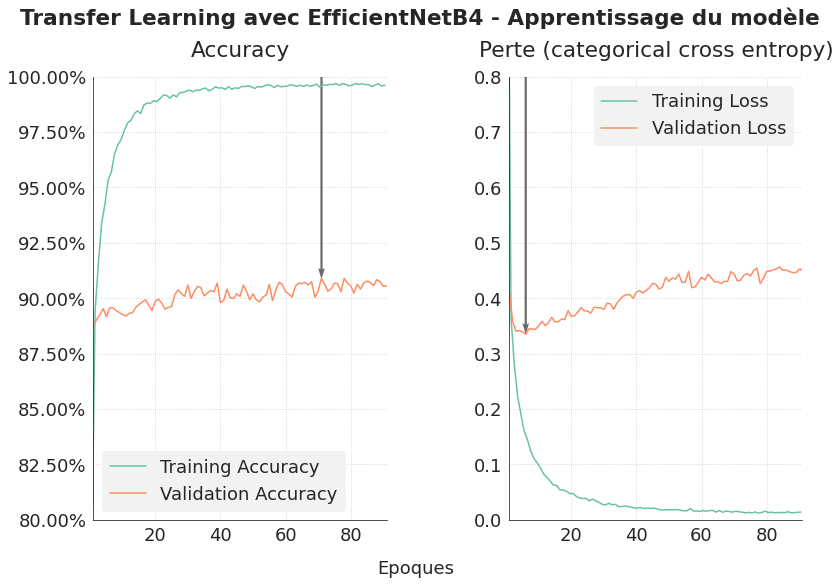

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Apprentissage du modèle",
                              history_csv, is_csv=True)
ax[0].set_ylim([0.8, 1.0])
ax[1].set_ylim([0, 0.8])
save_fig("iml06_transferlearning_base")
plt.show()

L'entraînement du modèle retenu pour le transfer learning nous amène à une accuracy de validation de 90,90%. C'est une performance bien meilleure que notre CNN de base.  
Je regarde si je peux encore améliorer la performance avec un fine-tuning du modèle.

<a id='3_4'></a>

### 3.4. Fine-tuning du modèle retenu

Le fine-tuning consiste à entraîner les couches supérieures du modèle pré-entraîné afin d'ajuster légèrement les poids de ces couches. L'objectif est de voir si on peut adapter les dernières features à notre problématique spécifique.

On repart du modèle entraîné sur la seule couche de classification. Puis on applique un apprentissage avec un taux d'apprentissage très faible (1e-5) sur une ou plusieurs couches (les plus hautes) d'EfficientNetB4, en plus de notre couche dense de classification.

In [ ]:
model = best_transfer_learning()

71688192/71686520 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
model.get_layer("efficientnetb4").summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 256, 256, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 257, 257, 3)  0           normalization_1[0][0]            
_____________________________________________________________________________________

En analysant la composition d'EfficientNetB4, je vois que la couche la plus haute avec des paramètres est la troisième en partant de la fin : une couche BatchNormalization appelée "top_bn". Elle est précédée d'une couche convolutionnelle "top_conv". Si je veux faire le fine-tuning sur une seule couche, je remonte donc à cette quatrième couche "top_conv" et je mets également à jour la couche batch normalization "top_bn" qui normalise sa sortie.

Cette couche "top_conv" suit la concaténation de deux branches qui finissent chacune par une batch normailization appliquée à une couche convolutionnelle ("block7b_project_conv" et "block7a_project_conv"). Si je souhaite pousser plus loin le transfer learning, je peux essayer de faire le fine-tuning soit sur block7b_project_conv (huitième couche en partant de la fin), soit sur block7b_project_conv (vingt-et-unième couche en partant de la fin), soit sur ces deux parties simultanément, ainsi que sur la couche qui normalise leur sortie (block7b_project_bn et block7a_project_bn).

Je teste donc le fine tuning sur une ou deux couches paramétrables d'EfficientNetB4, avec trois possibilités dans le cas de deux couches.

In [ ]:
model.get_layer("efficientnetb4").layers[-4].name

'top_conv'

In [ ]:
model.get_layer("efficientnetb4").layers[-8].name

'block7b_project_conv'

In [ ]:
model.get_layer("efficientnetb4").layers[-21].name

'block7a_project_conv'

Il faut appliquer à nouveau le pré-processing des données en entrée du modèle sauvegardé. J'ai créé une méthode pour cela (cf "Notebook set-up" au début du Notebook).

#### 3.4.1. Fine-tuning d'une seule couche d'EfficientNetB4

Pour entraîner la dernière couche paramétrable d'EfficientNetB4, il faut entraîner la couche "top_conv".  
Je crée à nouveau le même modèle, et je recharge les poids issus de l'entraînement. J'applique un taux d'apprentissage volontairement faible (1e-5) car je ne veux pas détruire mon apprentissage précédent. Je souhaite juste l'ajuster pour qu'il colle mieux à ma problématique spécifique.

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "onelayer"

In [ ]:
model = best_transfer_learning(list_trainable_layers=["top_conv", "top_bn"], learning_rate=1e-5)
model.load_weights("weights/transferlearning_trained")
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 1,021,560
Non-trainable params: 16,867,423
_________________________________________________________________


Je vérifie la performance de validation du modèle, pour m'assurer que le modèle entraîné est bien rechargé.

In [ ]:
model.evaluate(data_valid, return_dict=True)

103/103 [==============================] - 2133s 21s/step - loss: 0.4319 - accuracy: 0.9084


{'accuracy': 0.9083737730979919, 'loss': 0.431938111782074}

L'accuracy correspond à notre modèle entraîné. Je poursuis avec le fine tuning.

In [ ]:
es_patience = 20
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history12 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback])

Epoch 1/1000
412/412 - 8405s - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.4198 - val_accuracy: 0.9111
Epoch 2/1000
412/412 - 246s - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.4165 - val_accuracy: 0.9117
Epoch 3/1000
412/412 - 245s - loss: 0.0058 - accuracy: 0.9979 - val_loss: 0.4153 - val_accuracy: 0.9120
Epoch 4/1000
412/412 - 242s - loss: 0.0038 - accuracy: 0.9979 - val_loss: 0.4125 - val_accuracy: 0.9120
Epoch 5/1000
412/412 - 244s - loss: 0.0037 - accuracy: 0.9979 - val_loss: 0.4143 - val_accuracy: 0.9126
Epoch 6/1000
412/412 - 242s - loss: 0.0040 - accuracy: 0.9979 - val_loss: 0.4130 - val_accuracy: 0.9126
Epoch 7/1000
412/412 - 243s - loss: 0.0037 - accuracy: 0.9979 - val_loss: 0.4131 - val_accuracy: 0.9135
Epoch 8/1000
412/412 - 243s - loss: 0.0037 - accuracy: 0.9979 - val_loss: 0.4123 - val_accuracy: 0.9144
Epoch 9/1000
412/412 - 241s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.4081 - val_accuracy: 0.9141
Epoch 10/1000
412/412 - 241s - loss: 0.0035 - accuracy: 0.9979 

In [ ]:
history12_csv = pd.DataFrame(history12.history)
history12_csv.to_csv("history_{}.csv".format(SUB_MODEL))
#model.save("transferlearning_fitted_onelayer")
model.save_weights("weights/transferlearning_fitted_onelayer")

In [ ]:
history_csv = pd.read_csv("history_onelayer.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,0.004870,0.998481,0.419812,0.911104
1,0.004209,0.998101,0.416480,0.911711
2,0.005849,0.997950,0.415335,0.912015
3,0.003839,0.997950,0.412483,0.912015
4,0.003699,0.997950,0.414279,0.912621


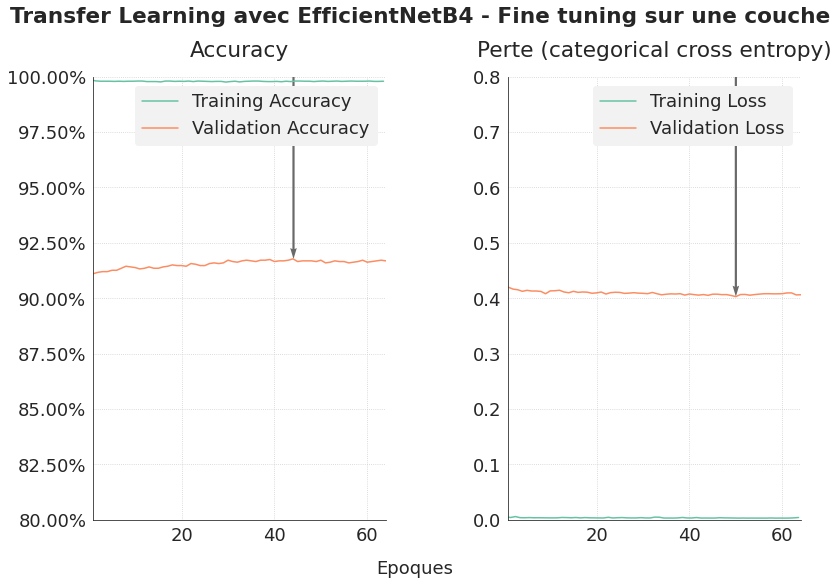

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur une couche",
                              history_csv, is_csv=True)
ax[0].set_ylim([0.8, 1.0])
ax[1].set_ylim([0, 0.8])
plt.show()

J'obtiens une accuracy de validation de 91,78% en effectuant le fine-tuning d'une couche d'EfficientNetB4. Cela représente une amélioration intéressante de 0.88% de l'accuracy de validation.

Je recrée un graphique avec l'apprentissage initial sans le fine-tuning. Pour cela, je recharge les données de l'apprentissage du modèle retenu et j'enlève les 20 dernières époques pour m'arrêter à la meilleure performance obtenue.  
Puis j'ajoute les nouvelles données d'optimisation.

In [ ]:
history_all = pd.read_csv("history_onlytop.csv", index_col=0)
nb_init = len(history_all) - 20
history_all = history_all.iloc[:nb_init].copy()
history_all = pd.concat([history_all, history_csv], ignore_index=True)
print(history_all.head())
print(history_all.tail())

       loss  accuracy  val_loss  val_accuracy
0  1.188182  0.782959  0.408736      0.887743
1  0.363815  0.893909  0.358743      0.890473
2  0.279892  0.915401  0.340327      0.892597
3  0.224097  0.933627  0.341624      0.895328
4  0.190893  0.942284  0.339356      0.891687
         loss  accuracy  val_loss  val_accuracy
130  0.003078  0.997950  0.408214      0.916262
131  0.003048  0.998026  0.409583      0.916566
132  0.003126  0.997874  0.409649      0.916869
133  0.003497  0.997874  0.406041      0.917172
134  0.004145  0.997950  0.406279      0.916869


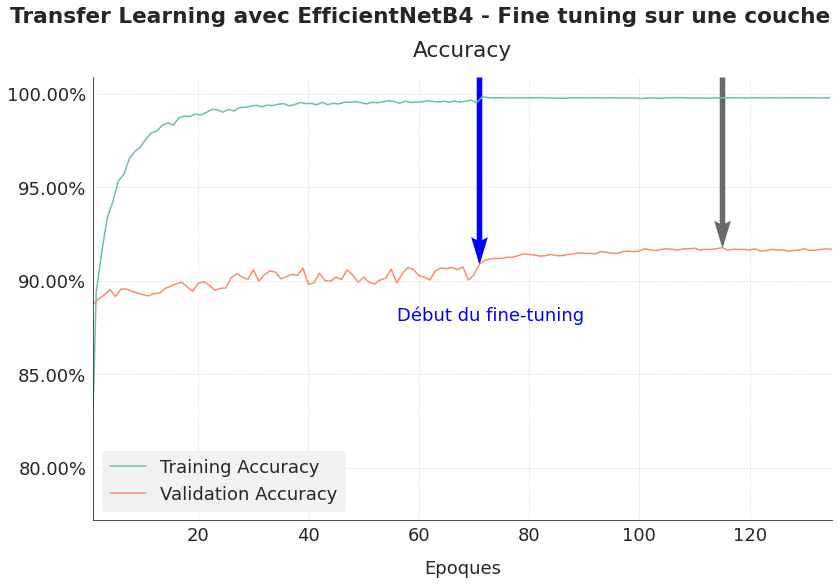

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur une couche",
                              history_all, is_csv=True, only_accuracy=True)
#ax[0].set_ylim([0.8, 1.0])
ymin, ymax = ax[0].get_ylim()
ax[0].quiver(nb_init, ymax, 0, history_all.iloc[nb_init-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="blue")
ax[0].text(nb_init - 15, history_all.iloc[nb_init-1].val_accuracy - 0.03, "Début du fine-tuning", color="blue")
save_fig("iml06_transferlearning_finetuning_one")
plt.show()

In [ ]:
history_all.to_csv("graph_finetuning_onelayer.csv")

#### 3.4.2. Fine-tuning d'une deuxième couche d'EfficientNetB4 : block7b_project_conv

Je repars du modèle avec un layer optimisé. Et j'applique une optimisation sur la couche suivante. Pour commencer, je choisis d'optimiser seulement une branche : block7b_project_conv.  
J'applique un learning rate plus faible (divisé par deux par rapport à l'étape précédente) : 5e-6.

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "twolayers_block7b"

In [ ]:
model = best_transfer_learning(list_trainable_layers=["top_conv", "top_bn",
                                                      "block7b_project_conv", "block7b_project_bn"],
                               learning_rate=5e-6)
model.load_weights("weights/transferlearning_fitted_onelayer")
model.summary()

71688192/71686520 [==============================] - 3s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 2,226,680
Non-trainable params: 15,662,303
_________________________________________________________________


Je vérifie la performance de validation du modèle, pour m'assurer que le modèle avec les paramètres de la dernière couche optimisés est bien rechargé.

In [ ]:
model.evaluate(data_valid, return_dict=True)

103/103 [==============================] - 2119s 21s/step - loss: 0.4073 - accuracy: 0.9172


{'accuracy': 0.9171723127365112, 'loss': 0.4073446989059448}

L'accuracy correspond à notre modèle entraîné. Je poursuis avec le fine tuning.

In [ ]:
es_patience = 20
#checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
#                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history13 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[earlystop_callback])

Epoch 1/1000
412/412 - 8370s - loss: 0.0048 - accuracy: 0.9980 - val_loss: 0.4152 - val_accuracy: 0.9169
Epoch 2/1000
412/412 - 257s - loss: 0.0038 - accuracy: 0.9979 - val_loss: 0.4163 - val_accuracy: 0.9160
Epoch 3/1000
412/412 - 258s - loss: 0.0053 - accuracy: 0.9976 - val_loss: 0.4144 - val_accuracy: 0.9172
Epoch 4/1000
412/412 - 258s - loss: 0.0036 - accuracy: 0.9980 - val_loss: 0.4150 - val_accuracy: 0.9181
Epoch 5/1000
412/412 - 257s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.4182 - val_accuracy: 0.9169
Epoch 6/1000
412/412 - 258s - loss: 0.0036 - accuracy: 0.9978 - val_loss: 0.4179 - val_accuracy: 0.9184
Epoch 7/1000
412/412 - 257s - loss: 0.0035 - accuracy: 0.9979 - val_loss: 0.4198 - val_accuracy: 0.9175
Epoch 8/1000
412/412 - 256s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.4200 - val_accuracy: 0.9184
Epoch 9/1000
412/412 - 258s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.4187 - val_accuracy: 0.9181
Epoch 10/1000
412/412 - 256s - loss: 0.0035 - accuracy: 0.9979 

In [ ]:
history13_csv = pd.DataFrame(history13.history)
history13_csv.to_csv("history_{}.csv".format(SUB_MODEL))
#model.save("transferlearning_fitted_twolayers_block7b")
model.save_weights("weights/transferlearning_fitted_twolayers_block7b")

In [ ]:
history_csv = pd.read_csv("history_twolayers_block7b.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,0.004775,0.998026,0.415159,0.916869
1,0.003831,0.997874,0.416331,0.915959
2,0.005298,0.997646,0.414413,0.917172
3,0.003591,0.998026,0.415041,0.918083
4,0.003550,0.997950,0.418249,0.916869


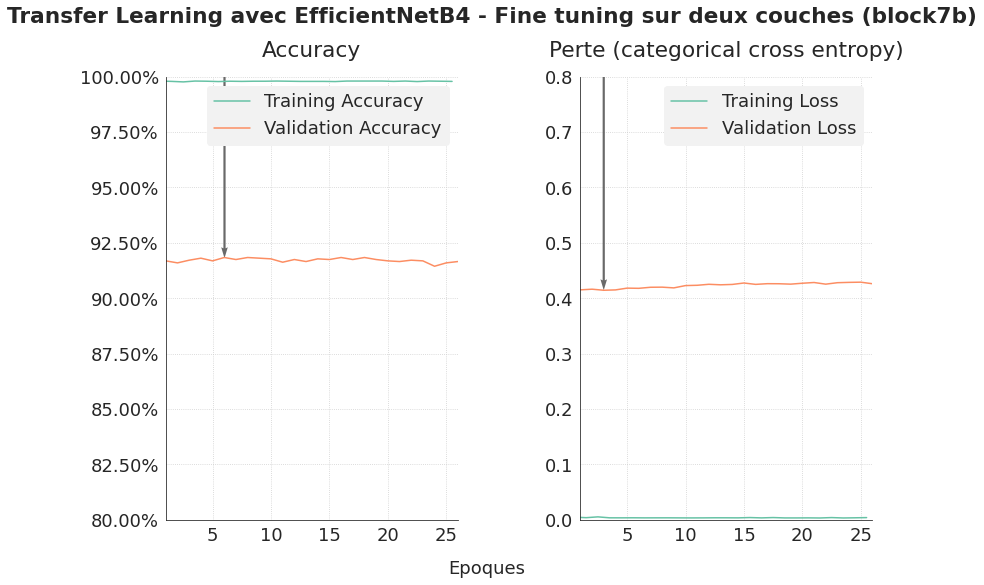

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur deux couches (block7b)",
                              history_csv, is_csv=True)
ax[0].set_ylim([0.8, 1.0])
ax[1].set_ylim([0, 0.8])
plt.show()

En ajoutant le fine-tuning de la dernière couche convolutionnelle de block7b, l'accuracy de validation passe de 91,78% à 91,84%. Cela représente une très faible amélioration, sachant que le nombre de paramètres optimisés fait plus que doubler (de 1 021 560 à 2 226 680), ce qui présente un risque d'overfitting.

In [ ]:
history_all = pd.read_csv("graph_finetuning_onelayer.csv", index_col=0)
nb_onelayer = len(history_all) - 20
history_all = history_all.iloc[:nb_onelayer].copy()
history_all = pd.concat([history_all, history_csv], ignore_index=True)
print(history_all.head())
print(history_all.tail())

       loss  accuracy  val_loss  val_accuracy
0  1.188182  0.782959  0.408736      0.887743
1  0.363815  0.893909  0.358743      0.890473
2  0.279892  0.915401  0.340327      0.892597
3  0.224097  0.933627  0.341624      0.895328
4  0.190893  0.942284  0.339356      0.891687
         loss  accuracy  val_loss  val_accuracy
136  0.003287  0.998026  0.425420      0.917172
137  0.004012  0.997798  0.428053      0.916869
138  0.003315  0.998026  0.428652      0.914442
139  0.003610  0.997950  0.429000      0.915959
140  0.003978  0.997874  0.426169      0.916566


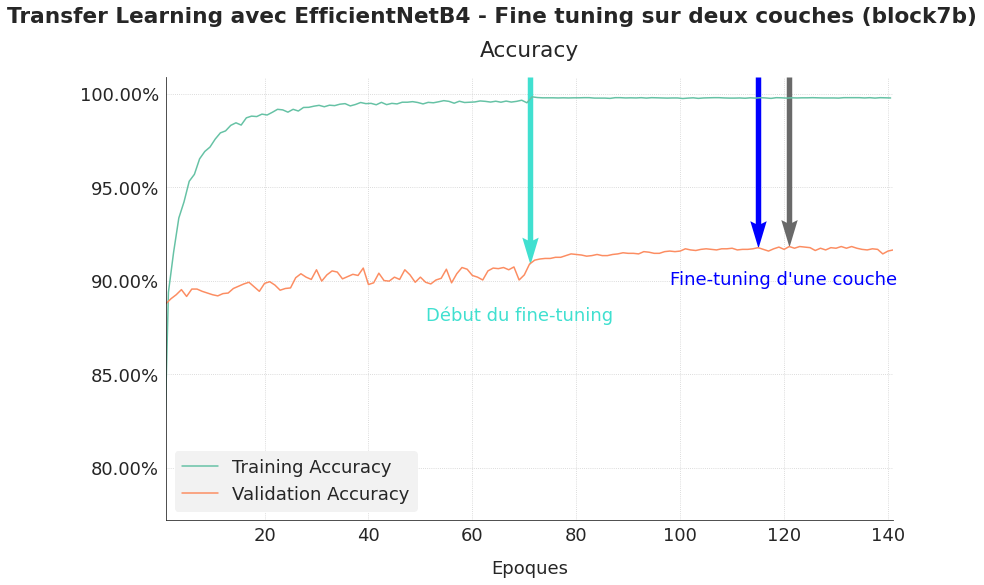

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur deux couches (block7b)",
                              history_all, is_csv=True, only_accuracy=True)
ymin, ymax = ax[0].get_ylim()
ax[0].quiver(nb_init, ymax, 0, history_all.iloc[nb_init-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="turquoise")
ax[0].text(nb_init - 20, history_all.iloc[nb_init-1].val_accuracy - 0.03, "Début du fine-tuning", color="turquoise")
ax[0].quiver(nb_onelayer, ymax, 0, history_all.iloc[nb_onelayer-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="blue")
ax[0].text(nb_onelayer - 17, history_all.iloc[nb_onelayer-1].val_accuracy - 0.02, "Fine-tuning d'une couche", color="blue")
save_fig("iml06_transferlearning_finetuning_block7b")
plt.show()

#### 3.4.3. Fine-tuning d'une deuxième couche d'EfficientNetB4 : block7a_project_conv

Je regarde maintenant les résultats en optimisant block7a_project_conv à la place de block7b_project_conv.

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "twolayers_block7a"

In [ ]:
model = best_transfer_learning(list_trainable_layers=["top_conv", "top_bn",
                                                      "block7a_project_conv", "block7a_project_bn"],
                               learning_rate=5e-6)
model.load_weights("weights/transferlearning_fitted_onelayer")
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 1,753,592
Non-trainable params: 16,135,391
_________________________________________________________________


Je vérifie la performance de validation du modèle, pour m'assurer que le modèle avec les paramètres de la dernière couche optimisés est bien rechargé.

In [ ]:
model.evaluate(data_valid, return_dict=True)

103/103 [==============================] - 51s 493ms/step - loss: 0.4072 - accuracy: 0.9172


{'accuracy': 0.9171723127365112, 'loss': 0.40719935297966003}

L'accuracy correspond à notre modèle entraîné. Je poursuis avec le fine tuning.

In [ ]:
es_patience = 20
#checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
#                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history14 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[earlystop_callback])

Epoch 1/1000
412/412 - 266s - loss: 0.0047 - accuracy: 0.9980 - val_loss: 0.4093 - val_accuracy: 0.9157
Epoch 2/1000
412/412 - 268s - loss: 0.0039 - accuracy: 0.9979 - val_loss: 0.4084 - val_accuracy: 0.9150
Epoch 3/1000
412/412 - 268s - loss: 0.0044 - accuracy: 0.9978 - val_loss: 0.4084 - val_accuracy: 0.9154
Epoch 4/1000
412/412 - 268s - loss: 0.0038 - accuracy: 0.9979 - val_loss: 0.4089 - val_accuracy: 0.9150
Epoch 5/1000
412/412 - 268s - loss: 0.0038 - accuracy: 0.9979 - val_loss: 0.4110 - val_accuracy: 0.9154
Epoch 6/1000
412/412 - 268s - loss: 0.0049 - accuracy: 0.9976 - val_loss: 0.4082 - val_accuracy: 0.9169
Epoch 7/1000
412/412 - 267s - loss: 0.0048 - accuracy: 0.9979 - val_loss: 0.4064 - val_accuracy: 0.9160
Epoch 8/1000
412/412 - 267s - loss: 0.0036 - accuracy: 0.9979 - val_loss: 0.4067 - val_accuracy: 0.9160
Epoch 9/1000
412/412 - 267s - loss: 0.0036 - accuracy: 0.9980 - val_loss: 0.4079 - val_accuracy: 0.9157
Epoch 10/1000
412/412 - 268s - loss: 0.0035 - accuracy: 0.9980 -

In [ ]:
history14_csv = pd.DataFrame(history14.history)
history14_csv.to_csv("history_{}.csv".format(SUB_MODEL))
#model.save("transferlearning_fitted_twolayers_block7a")
model.save_weights("weights/transferlearning_fitted_twolayers_block7a")

In [ ]:
history_csv = pd.read_csv("history_twolayers_block7a.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,0.004735,0.998026,0.409322,0.915655
1,0.003925,0.997950,0.408353,0.915049
2,0.004376,0.997798,0.408359,0.915352
3,0.003798,0.997950,0.408913,0.915049
4,0.003752,0.997950,0.410970,0.915352


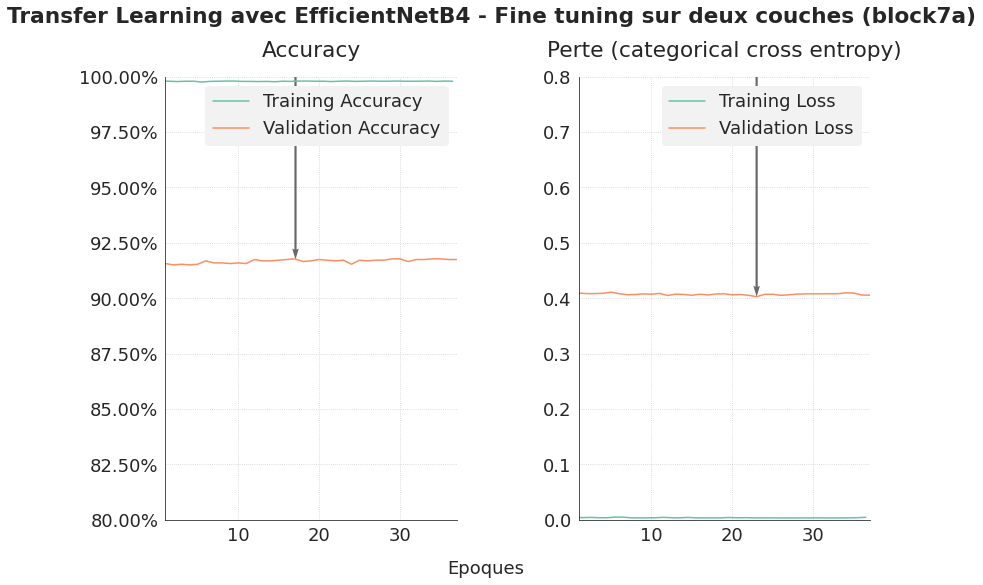

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur deux couches (block7a)",
                              history_csv, is_csv=True)
ax[0].set_ylim([0.8, 1.0])
ax[1].set_ylim([0, 0.8])
plt.show()

En ajoutant le fine-tuning de la dernière couche convolutionnelle de block7a, l'accuracy de validation ne s'améliore pas : elle reste égale à 91,78%, malgré l'augmentation du nombre de paramètres entraînés.

In [ ]:
history_all = pd.read_csv("graph_finetuning_onelayer.csv", index_col=0)
nb_onelayer = len(history_all) - 20
history_all = history_all.iloc[:nb_onelayer].copy()
history_all = pd.concat([history_all, history_csv], ignore_index=True)
print(history_all.head())
print(history_all.tail())

       loss  accuracy  val_loss  val_accuracy
0  1.188182  0.782959  0.408736      0.887743
1  0.363815  0.893909  0.358743      0.890473
2  0.279892  0.915401  0.340327      0.892597
3  0.224097  0.933627  0.341624      0.895328
4  0.190893  0.942284  0.339356      0.891687
         loss  accuracy  val_loss  val_accuracy
147  0.003450  0.997950  0.408131      0.917476
148  0.003431  0.998026  0.409692      0.917779
149  0.003532  0.997874  0.409445      0.917779
150  0.003820  0.998026  0.405713      0.917476
151  0.004563  0.997950  0.405572      0.917476


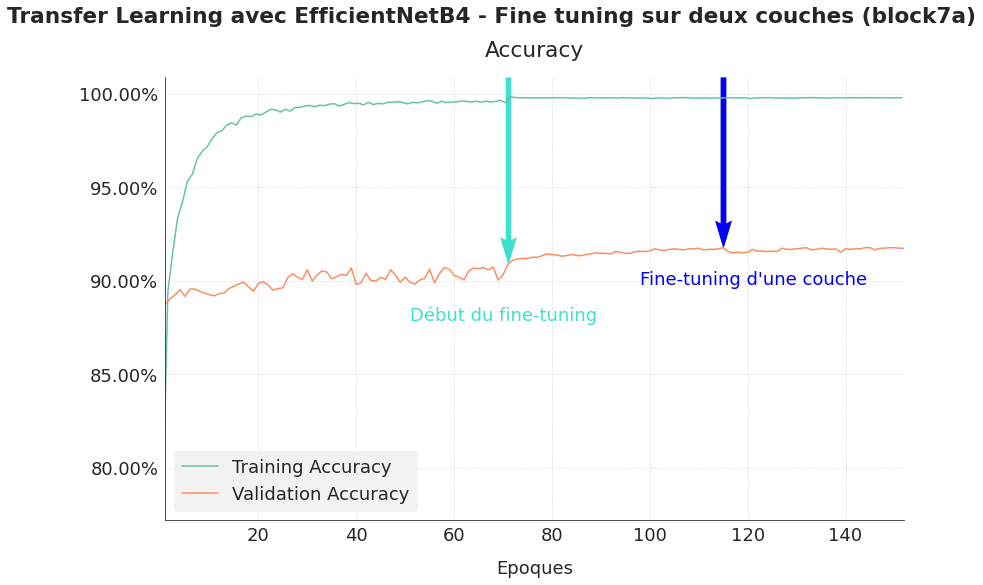

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur deux couches (block7a)",
                              history_all, is_csv=True, only_accuracy=True)
ymin, ymax = ax[0].get_ylim()
ax[0].quiver(nb_init, ymax, 0, history_all.iloc[nb_init-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="turquoise")
ax[0].text(nb_init - 20, history_all.iloc[nb_init-1].val_accuracy - 0.03, "Début du fine-tuning", color="turquoise")
ax[0].quiver(nb_onelayer, ymax, 0, history_all.iloc[nb_onelayer-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="blue")
ax[0].text(nb_onelayer - 17, history_all.iloc[nb_onelayer-1].val_accuracy - 0.02, "Fine-tuning d'une couche", color="blue")
save_fig("iml06_transferlearning_finetuning_block7a")
plt.show()

#### 3.4.4. Fine-tuning sur trois couches : block7a_project_conv et block7b_project_conv en même temps

Je regarde maintenant les résultats en optimisant block7a_project_conv à la place de block7b_project_conv.

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "twolayers_both"

In [ ]:
model = best_transfer_learning(list_trainable_layers=["top_conv", "top_bn",
                                                      "block7a_project_conv", "block7a_project_bn",
                                                      "block7b_project_conv", "block7b_project_bn"],
                               learning_rate=5e-6)
model.load_weights("weights/transferlearning_fitted_onelayer")
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 2,958,712
Non-trainable params: 14,930,271
_________________________________________________________________


Je vérifie la performance de validation du modèle, pour m'assurer que le modèle avec les paramètres de la dernière couche optimisés est bien rechargé.

In [ ]:
model.evaluate(data_valid, return_dict=True)

103/103 [==============================] - 1512s 15s/step - loss: 0.4073 - accuracy: 0.9172


{'accuracy': 0.9171723127365112, 'loss': 0.40734463930130005}

L'accuracy correspond à notre modèle entraîné. Je poursuis avec le fine tuning.

In [ ]:
es_patience = 20
#checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
#                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history14 = model.fit(data_train, validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[earlystop_callback])

Epoch 1/1000
412/412 - 5981s - loss: 0.0067 - accuracy: 0.9982 - val_loss: 0.4172 - val_accuracy: 0.9154
Epoch 2/1000
412/412 - 148s - loss: 0.0046 - accuracy: 0.9981 - val_loss: 0.4171 - val_accuracy: 0.9150
Epoch 3/1000
412/412 - 146s - loss: 0.0061 - accuracy: 0.9976 - val_loss: 0.4142 - val_accuracy: 0.9166
Epoch 4/1000
412/412 - 145s - loss: 0.0042 - accuracy: 0.9980 - val_loss: 0.4150 - val_accuracy: 0.9169
Epoch 5/1000
412/412 - 145s - loss: 0.0042 - accuracy: 0.9979 - val_loss: 0.4180 - val_accuracy: 0.9172
Epoch 6/1000
412/412 - 145s - loss: 0.0042 - accuracy: 0.9978 - val_loss: 0.4171 - val_accuracy: 0.9181
Epoch 7/1000
412/412 - 145s - loss: 0.0040 - accuracy: 0.9979 - val_loss: 0.4188 - val_accuracy: 0.9181
Epoch 8/1000
412/412 - 145s - loss: 0.0041 - accuracy: 0.9979 - val_loss: 0.4189 - val_accuracy: 0.9187
Epoch 9/1000
412/412 - 144s - loss: 0.0041 - accuracy: 0.9979 - val_loss: 0.4175 - val_accuracy: 0.9181
Epoch 10/1000
412/412 - 144s - loss: 0.0040 - accuracy: 0.9979 

In [ ]:
history14_csv = pd.DataFrame(history14.history)
history14_csv.to_csv("history_{}.csv".format(SUB_MODEL))
#model.save("transferlearning_fitted_twolayers_block7a")
model.save_weights("weights/transferlearning_fitted_twolayers_both")

In [ ]:
history_csv = pd.read_csv("history_twolayers_both.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,0.006654,0.998177,0.417209,0.915352
1,0.004586,0.998101,0.417134,0.915049
2,0.006085,0.997646,0.414159,0.916566
3,0.004241,0.998026,0.415049,0.916869
4,0.004154,0.997950,0.417992,0.917172


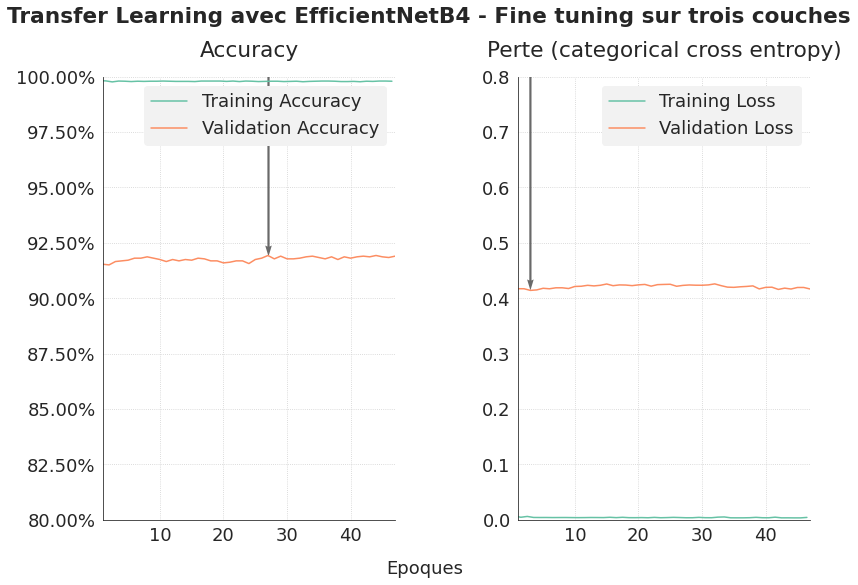

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur trois couches",
                              history_csv, is_csv=True)
ax[0].set_ylim([0.8, 1.0])
ax[1].set_ylim([0, 0.8])
plt.show()

En ajoutant le fine-tuning de la dernière couche convolutionnelle de block7b et de blocl7a, l'accuracy de validation monte à 91,93%. Par contre, le nombre de paramètres augmente fortement à 2 958 712, ce qui présente un risque d'overfitting vu le faible nombre d'images à notre disposition dans notre jeu d'entraînement..

In [ ]:
history_all = pd.read_csv("graph_finetuning_onelayer.csv", index_col=0)
nb_onelayer = len(history_all) - 20
history_all = history_all.iloc[:nb_onelayer].copy()
history_all = pd.concat([history_all, history_csv], ignore_index=True)
print(history_all.head())
print(history_all.tail())

       loss  accuracy  val_loss  val_accuracy
0  1.188182  0.782959  0.408736      0.887743
1  0.363815  0.893909  0.358743      0.890473
2  0.279892  0.915401  0.340327      0.892597
3  0.224097  0.933627  0.341624      0.895328
4  0.190893  0.942284  0.339356      0.891687
         loss  accuracy  val_loss  val_accuracy
157  0.003539  0.997950  0.418246      0.918689
158  0.003568  0.997874  0.416653      0.919296
159  0.003464  0.998026  0.419409      0.918689
160  0.003478  0.998026  0.419449      0.918386
161  0.004305  0.997950  0.416699      0.918993


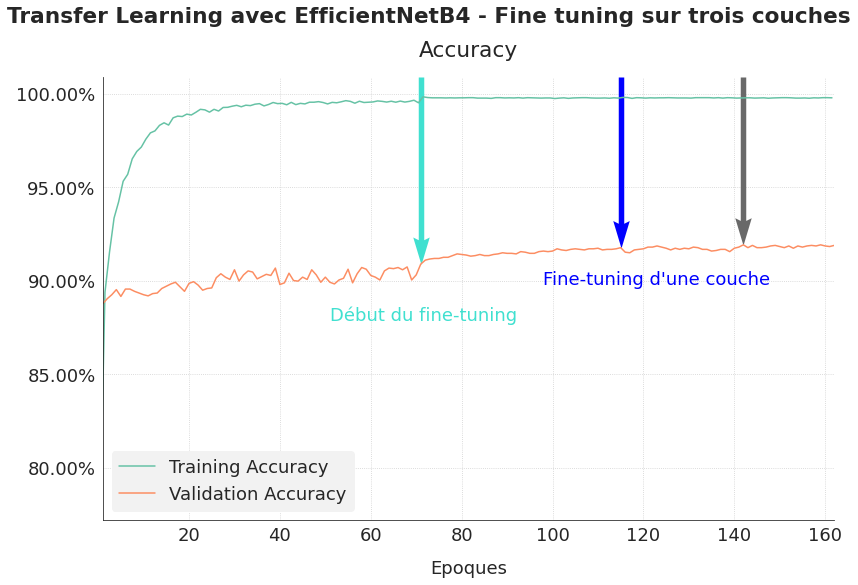

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Fine tuning sur trois couches",
                              history_all, is_csv=True, only_accuracy=True)
ymin, ymax = ax[0].get_ylim()
ax[0].quiver(nb_init, ymax, 0, history_all.iloc[nb_init-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="turquoise")
ax[0].text(nb_init - 20, history_all.iloc[nb_init-1].val_accuracy - 0.03, "Début du fine-tuning", color="turquoise")
ax[0].quiver(nb_onelayer, ymax, 0, history_all.iloc[nb_onelayer-1].val_accuracy - ymax,
             units="xy", scale_units="xy", scale=1, color="blue")
ax[0].text(nb_onelayer - 17, history_all.iloc[nb_onelayer-1].val_accuracy - 0.02, "Fine-tuning d'une couche", color="blue")
save_fig("iml06_transferlearning_finetuning_both")
plt.show()

#### 3.4.5. Comparaison de performance

In [ ]:
resultats = pd.DataFrame({"fine_tuning": ["Pas de fine tuning", "Une couche", "Deux couches (block 7a)",
                                    "Deux couches (block 7b)", "Trois couches"],
                          "trainable_param": [215160, 1021560, 1753592,
                                              2226680, 2958712],
                          "training_accuracy": [0.9953, 0.9978, 0.9979,
                                                0.9978, 0.9979],
                          "validation_accuracy": [0.9090, 0.9178, 0.9178,
                                                  0.9184, 0.9193]})
resultats

,fine_tuning,trainable_param,training_accuracy,validation_accuracy
0,Pas de fine tuning,215160,0.9953,0.9090
1,Une couche,1021560,0.9978,0.9178
2,Deux couches (block 7a),1753592,0.9979,0.9178
3,Deux couches (block 7b),2226680,0.9978,0.9184
4,Trois couches,2958712,0.9979,0.9193


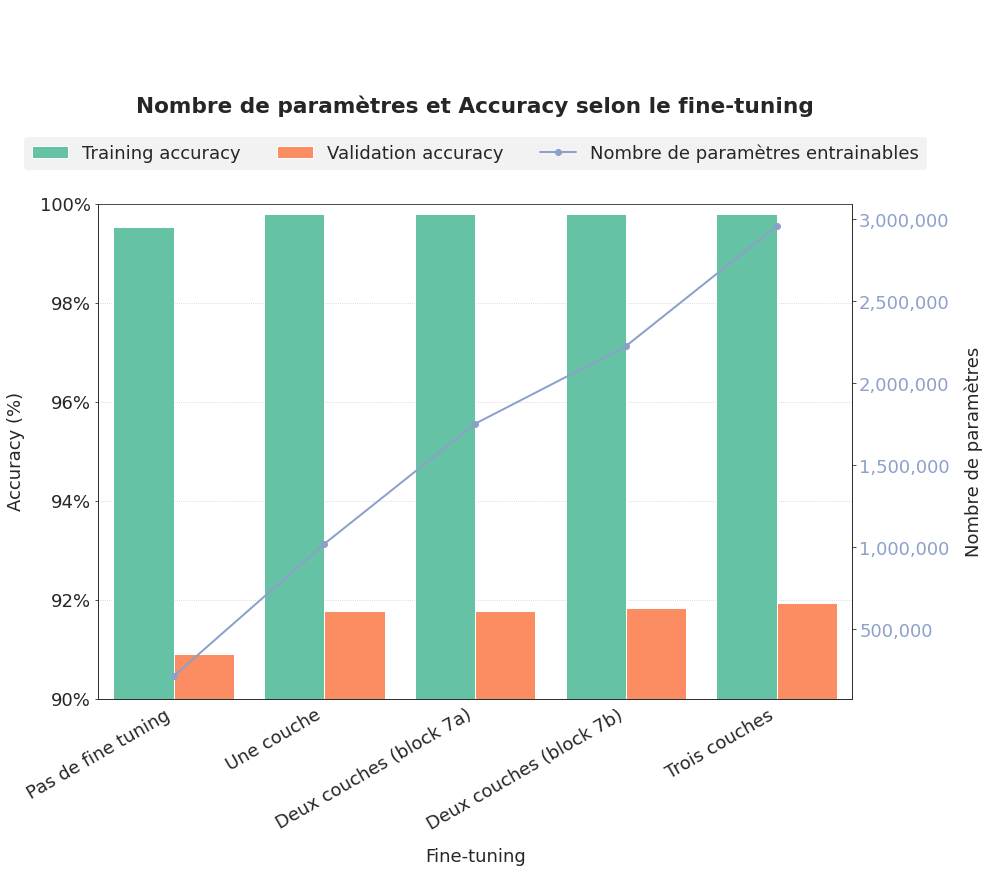

In [ ]:
graph = sfg.MyGraph("Nombre de paramètres et Accuracy selon le fine-tuning", y_title=1.125)
graph.add_barv(np.arange(len(resultats.fine_tuning))-0.2, resultats.training_accuracy,
               bar_width=0.4, label="Training accuracy")
graph.add_barv(np.arange(len(resultats.fine_tuning))+0.2, resultats.validation_accuracy,
               bar_width=0.4, label="Validation accuracy")
graph.add_plot(np.arange(len(resultats.fine_tuning)), resultats.trainable_param, marker="o", linewidth=2.0,
               color=graph.liste_couleurs[2], label="Nombre de paramètres entrainables", twinx=True)
graph.set_axe_x(label="Fine-tuning", rotation=30, ha="right",
                tick_min=0, tick_max=len(resultats.fine_tuning)-1, tick_step=1, tick_labels=resultats.fine_tuning)
graph.set_axe_x(tick_min=-0.5, tick_max=len(resultats.fine_tuning)-0.5)
graph.set_axe_y(label="Accuracy (%)", tick_labels_format=":.0%",
                tick_min=0.9, tick_max=1.0)
graph.set_axe_y(label="Nombre de paramètres", tick_labels_format=":,.0f",
                color=graph.liste_couleurs[2], multi_index=2)
graph.set_legend(loc="center", bbox_to_anchor=(0.55, 1.25), ncol=3, multi_index=0)
fig, ax = graph.fig, graph.ax
save_fig("iml06_compar_transferlearning_summary", tight_layout=False)
plt.show()

L'accuracy, de validation comme d'entraînement, est nettement améliorée par le fine-tuning de la dernière couche convolutionnelle d'EfficientNetB4. Le fine-tuning des couches précédentes ne permet pas d'améliorer significativement l'accuracy, surtout au regard de l'augmentation du nombre de paramètres entraînés, et du risque d'overfitting qui l'accompagne.

Je choisis donc de conserver le fine-tuning sur une seule couche convolutionnelle.

<a id='3_5'></a>

### 3.5. Enrichissement du modèle retenu par data augmentation

J'entraîne le modèle retenu avec une partie des données d'entraînement (data_mini) en y appliquant la data augmentation, afin de voir si cela améliore la performance.  
Pour rappel, nous avions une accuracy de validation de 89,62% après 50 époques avec ces mêmes données partielles sans augmentation de données.

In [ ]:
x_train = np.load("data_mini_x.npy")
y_train = np.load("data_mini_y.npy")

In [ ]:
MODEL_NAME = "transferlearning"
SUB_MODEL = "withdataaugmentation"

In [ ]:
model = best_transfer_learning(number_training_layers=0)
model.summary()

71688192/71686520 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
dense (Dense)                (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.2,
                             height_shift_range=0.2, horizontal_flip=True)

In [ ]:
es_patience = 50
logdir = os.path.join("logs", MODEL_NAME, SUB_MODEL)
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)
checkpoint_callback = ModelCheckpoint("model_{}.h5".format(SUB_MODEL),
                                      monitor="val_accuracy", save_best_only=True)
earlystop_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=es_patience,
                                   restore_best_weights=True)

In [ ]:
epochs = 1000
history15 = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      validation_data=data_valid, verbose=2,
                      epochs=epochs, callbacks=[checkpoint_callback,
                                                earlystop_callback,
                                                tensorboard_callback])

Epoch 1/1000
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
42/42 - 935s - loss: 3.9790 - accuracy: 0.3103 - val_loss: 2.9651 - val_accuracy: 0.6214
Epoch 2/1000
42/42 - 50s - loss: 2.1142 - accuracy: 0.7589 - val_loss: 1.7411 - val_accuracy: 0.7488
Epoch 3/1000
42/42 - 50s - loss: 1.1448 - accuracy: 0.8571 - val_loss: 1.1151 - val_accuracy: 0.8198
Epoch 4/1000
42/42 - 50s - loss: 0.6923 - accuracy: 0.9129 - val_loss: 0.8403 - val_accuracy: 0.8380
Epoch 5/1000
42/42 - 50s - loss: 0.4836 - accuracy: 0.9353 - val_loss: 0.7011 - val_accuracy: 0.8510
Epoch 6/1000
42/42 - 48s - loss: 0.3868 - accuracy: 0.9457 - val_loss: 0.6300 - val_accuracy: 0.8507
Epoch 7/1000
42/42 - 50s - loss: 0.3180 - accuracy: 0.9531 - val_loss: 0.5789 - val_accuracy: 0.8559
Epoch 8/1000
42/42 - 50s - loss: 0.2663 - accuracy: 0.9658 - val_loss: 0.5566 - val_accuracy: 0.8589
Epoch 9/1000
42/42 - 48s - loss: 0.2174 - accuracy: 0.9740 - val_loss: 0.5295 - val_accuracy: 0.8577
Epoch 10/1000
42/4

Je sauvegarde les résultats dans un fichier csv pour pouvoir y revenir facilement.

In [ ]:
history15_csv = pd.DataFrame(history15.history)
history15_csv.to_csv("history_{}.csv".format(SUB_MODEL))

In [ ]:
history_csv = pd.read_csv("history_withdataaugmentation.csv", index_col=0)
history_csv.head()

,loss,accuracy,val_loss,val_accuracy
0,3.978971,0.310268,2.965059,0.621359
1,2.114191,0.758929,1.741111,0.748786
2,1.144810,0.857143,1.115094,0.819782
3,0.692330,0.912946,0.840345,0.837985
4,0.483585,0.935268,0.701131,0.851032


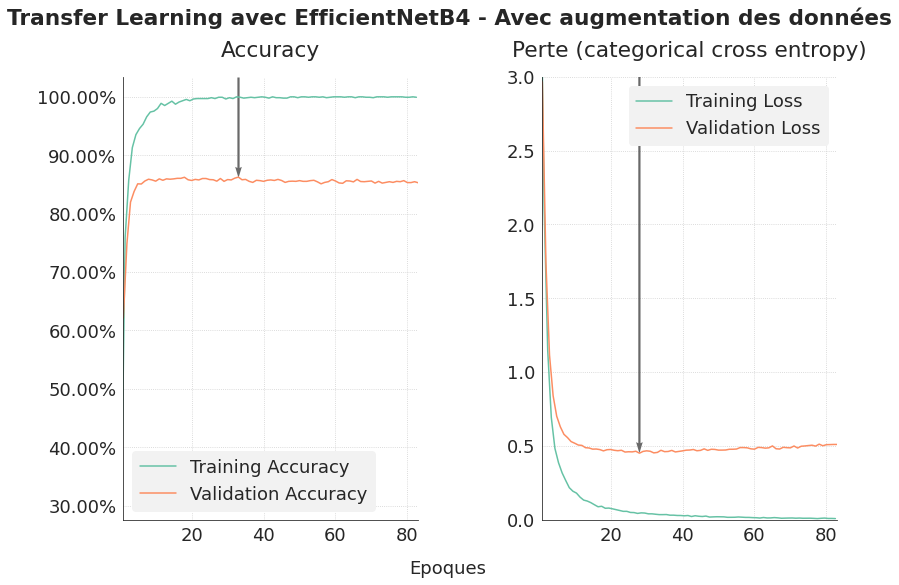

In [ ]:
fig, ax = graph_analysis_both("Transfer Learning avec EfficientNetB4 - Avec augmentation des données",
                              history_csv, is_csv=True)
ax[1].set_ylim([0, 3])
plt.show()

La data augmentation ne permet pas à ma couche de classification de mieux apprendre. J'abandonne cette piste.

---
<a id='4_0'></a>

## <font color=blue>4. Performance de généralisation du modèle retenu</font>

Le meilleur modèle est celui obtenu avec le fine-tuning sur une seule couche d'EfficientNetB4.  
Je recharge ce modèle et je l'évalue sur les données de test, jamais vues jusqu'ici, afin d'évaluer la performance de généralisation.

In [ ]:
model = best_transfer_learning()
model.load_weights("weights/transferlearning_fitted_onelayer")
model.summary()

71688192/71686520 [==============================] - 2s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 256, 256, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
classifier (Dense)           (None, 120)               215160    
Total params: 17,888,983
Trainable params: 215,160
Non-trainable params: 17,673,823
_________________________________________________________________


In [ ]:
model.evaluate(data_valid, return_dict=True)

103/103 [==============================] - 1740s 17s/step - loss: 0.4073 - accuracy: 0.9172


{'accuracy': 0.9171723127365112, 'loss': 0.40734463930130005}

Je retrouve une performance similaire. C'est le bon modèle qui est rechargé.

In [ ]:
model.evaluate(data_test, return_dict=True)

129/129 [==============================] - 2035s 16s/step - loss: 0.6232 - accuracy: 0.8780


{'accuracy': 0.8780369162559509, 'loss': 0.6232158541679382}

La performance de généralisation est légèrement inférieure avec une accuracy de 87,80% sur les données de test.  
Cela reste une bonne performance. Ce modèle peut être mis en production.

In [ ]:
model.save("model/dogs_model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model/dogs_model/assets


In [ ]:
import joblib

In [ ]:
joblib.dump(efficientnet_preprocess_input, 'model/dogs_preprocess.joblib')

['model/dogs_preprocess.joblib']